In [1]:
# The first thing we should do is to apply hardware acceleration via GPU. So, we have to go to Editar - Configuracion del Cuaderno - Acelerador por Hardware GPU

# Now we SET UP Fastai
!pip install -Uqq fastbook
!pip install nbdev
import fastbook
fastbook.setup_book()
import fastai
import fastcore
print(f'fastcore version {fastcore.__version__} installed')
print(f'fastai version {fastai.__version__} installed')
from nbdev.showdoc import *
from fastai.vision.all import *

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Function to display evaluation metrics
# Developed by Ignacio Oguiza: https://forums.fast.ai/t/plotting-metrics-after-learning/69937

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def plot_label_counts(dls):
    # Extraer y convertir las etiquetas a enteros:
    train_labels = [int(dls.train_ds[i][1]) for i in range(len(dls.train_ds))]
    valid_labels = [int(dls.valid_ds[i][1]) for i in range(len(dls.valid_ds))]

    # Contar el número de elementos por etiqueta:
    train_counts = Counter(train_labels)
    valid_counts = Counter(valid_labels)

    # Obtenemos el vocabulario (lista de nombres de clases) y el número de clases:
    vocab = dls.vocab
    n_classes = len(vocab)

    # Crear listas de conteos usando los índices (0, 1, ..., n_classes-1)
    train_data = [train_counts[i] for i in range(n_classes)]
    valid_data = [valid_counts[i] for i in range(n_classes)]

    # Configurar el gráfico de barras agrupadas:
    x = np.arange(n_classes)
    width = 0.35

    fig, ax = plt.subplots(figsize=(10,6))
    ax.bar(x - width/2, train_data, width, label='Train', color='blue')
    ax.bar(x + width/2, valid_data, width, label='Valid', color='yellow')

    ax.set_ylabel('Número de elementos')
    ax.set_xticks(x)
    ax.set_xticklabels(vocab)
    ax.legend()

    plt.show()


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Apartado 1

In [5]:
import os
import shutil
from pathlib import Path
from torchvision import datasets
from fastai.vision.all import *
import torch.nn as nn
import torch
from PIL import Image

# 1. Configurar FASTAI_HOME y definir rutas base
os.environ["FASTAI_HOME"] = str(Path('/content/dataset'))

base_path = Path('/content/dataset')
fashion_path = base_path / "fashion_mnist"  # Ruta donde se descargará FashionMNIST

# 2. Descargar FashionMNIST con torchvision (se obtienen imágenes PIL al usar transform=None)
train_dataset = datasets.FashionMNIST(root=str(fashion_path), train=True, download=True)
test_dataset  = datasets.FashionMNIST(root=str(fashion_path), train=False, download=True)

# 3. Definir la estructura de carpetas destino: /content/dataset/original/fashion_mnist/{train,test}/{clase}/imagen.png
dest_base   = base_path / "original" / "fashion_mnist"
train_folder = dest_base / "train"
test_folder  = dest_base / "test"

train_folder.mkdir(parents=True, exist_ok=True)
test_folder.mkdir(parents=True, exist_ok=True)

# Obtener los nombres de clases del dataset (por ejemplo: 'T-shirt/top', 'Trouser', etc.)
classes = train_dataset.classes

for idx, (img, label) in enumerate(train_dataset):
    label_name = classes[label]
    out_dir = train_folder / label_name
    out_dir.mkdir(parents=True, exist_ok=True)
    out_file = out_dir / f"{idx}.png"
    img.save(out_file)

# Guardar imágenes de test organizadas en carpetas por clase
for idx, (img, label) in enumerate(test_dataset):
    label_name = classes[label]
    out_dir = test_folder / label_name
    out_dir.mkdir(parents=True, exist_ok=True)
    out_file = out_dir / f"{idx}.png"
    img.save(out_file)


100%|██████████| 26.4M/26.4M [00:02<00:00, 11.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 201kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.80MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.2MB/s]


## Lenet

In [6]:
dataset_root = train_folder

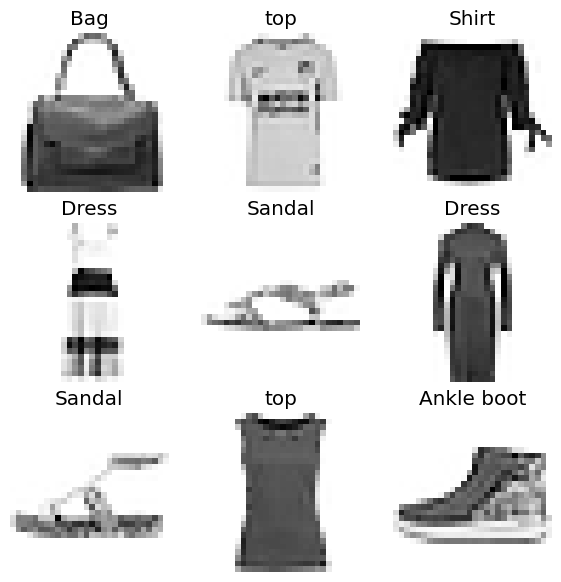

In [ ]:
# Creamos el DataBlock
blocks = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.2, seed=42)
)

# Generar DataLoaders a partir de la ruta indicada
dls = blocks.dataloaders(dataset_root, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))


Número total de imágenes en entrenamiento: 48000
Número total de imágenes en validación: 12000

Clases: ['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'Trouser', 'top']


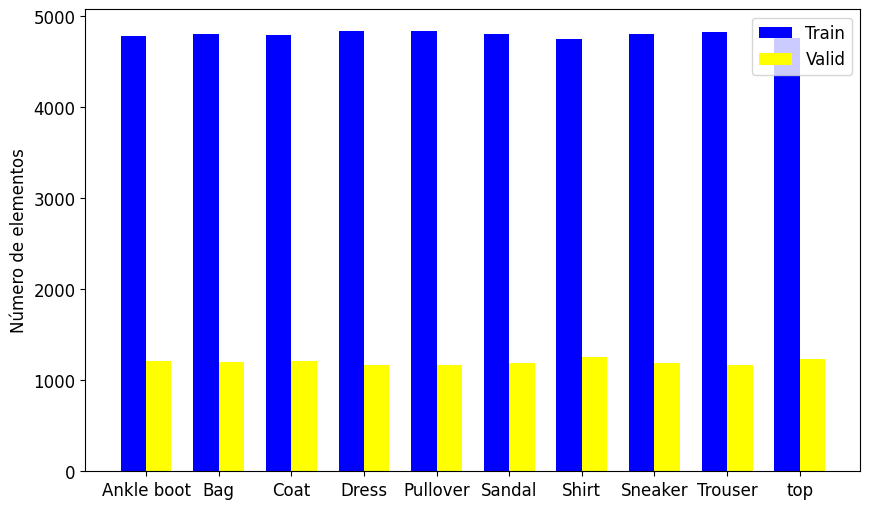

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [19]:
import torch.nn.functional as F

class LeNet(nn.Module):
  def __init__(self, num_classes=10):
    super(LeNet, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
    self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.fc1 = nn.Linear(16 * 4 * 4, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, num_classes)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = x.view(x.size(0), -1)  # Aplanar la salida
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

learn.summary()

LeNet (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 6 x 24 x 24    
Conv2d                                    156        True      
____________________________________________________________________________
                     64 x 16 x 8 x 8     
Conv2d                                    2416       True      
____________________________________________________________________________
                     64 x 16 x 4 x 4     
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 120            
Linear                                    30840      True      
____________________________________________________________________________
                     64 x 84             
Linear                                    10164      True      
____________________________________________________________

In [ ]:
start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")


Tiempo de entrenamiento: 1113.23 segundos


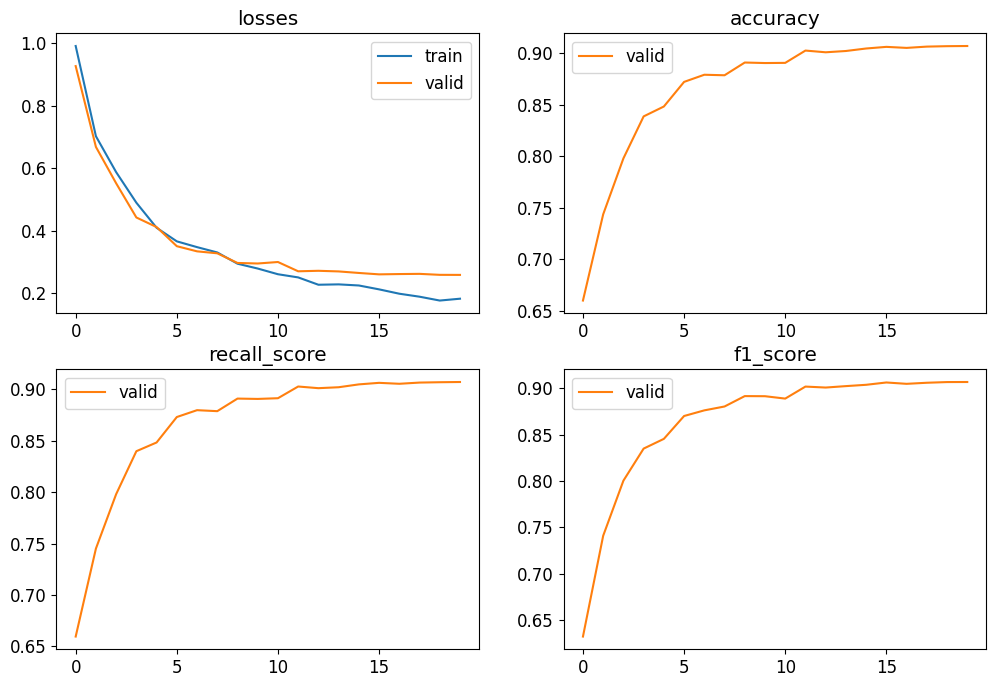

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.2586
Accuracy: 0.9067
Recall: 0.9072
F1-Score: 0.9068


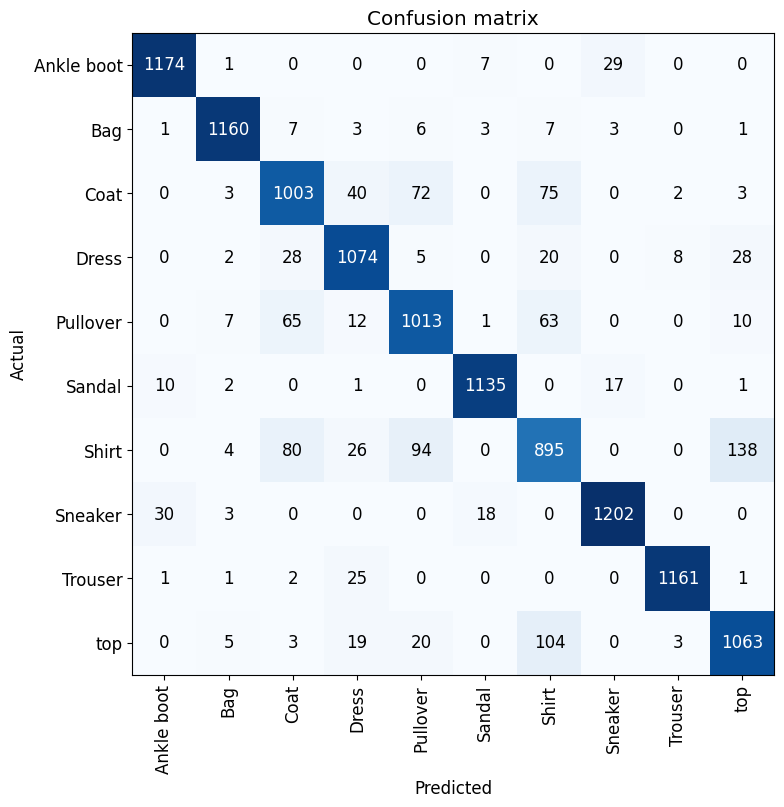

In [ ]:
#Creamos la interpretación de nuestro learner
interp = ClassificationInterpretation.from_learner(learn)

#Visualizamos la matriz de confusión
interp.plot_confusion_matrix(figsize=(8,8), dpi=100)

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_original_v3.pkl')

## Resnet

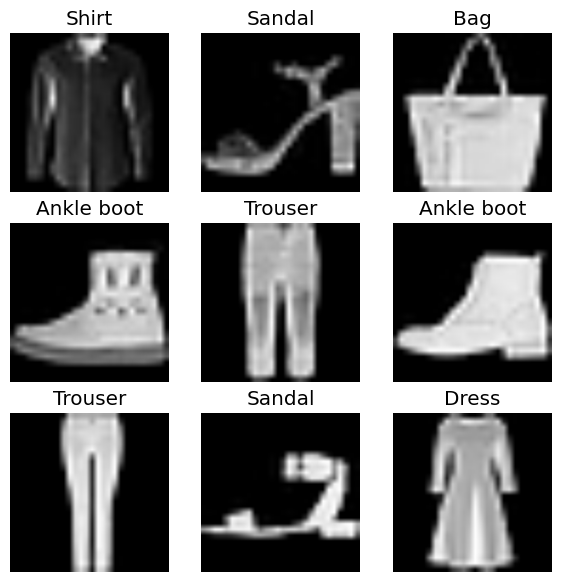

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224),
    )

dls = dblock.dataloaders(dataset_root, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))


In [ ]:
# Crear el learner con resnet18
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])
learn.summary()

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                      

In [ ]:
# Entrenar el modelo
start_time = time.time()
learn.fit_one_cycle(30)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 8: early stopping

Tiempo de entrenamiento: 2927.82 segundos


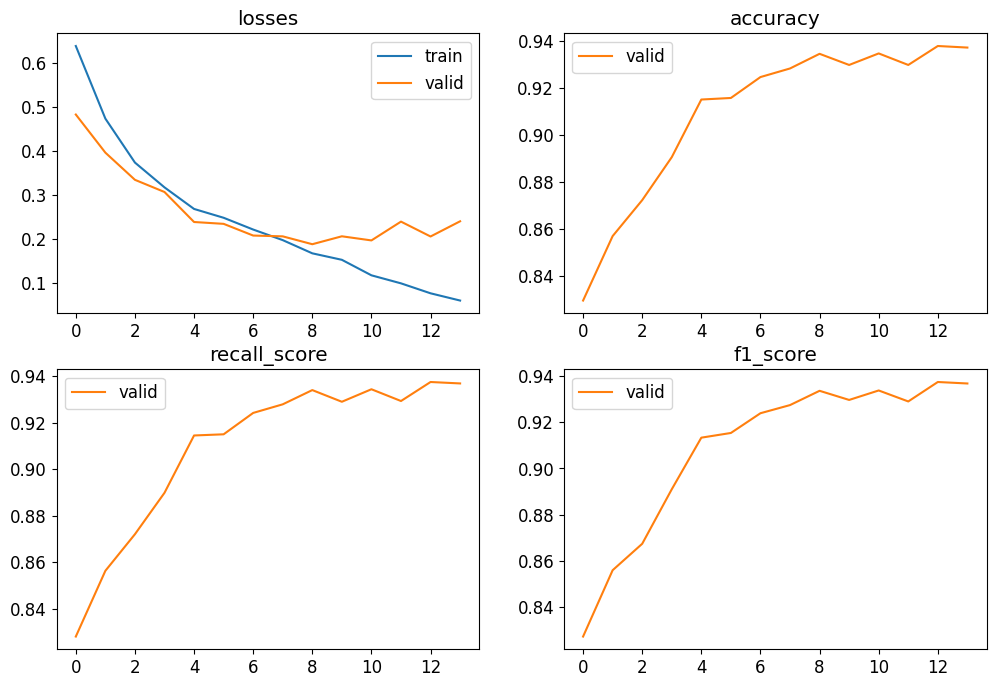

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.2396
Accuracy: 0.9373
Recall: 0.9369
F1-Score: 0.9368


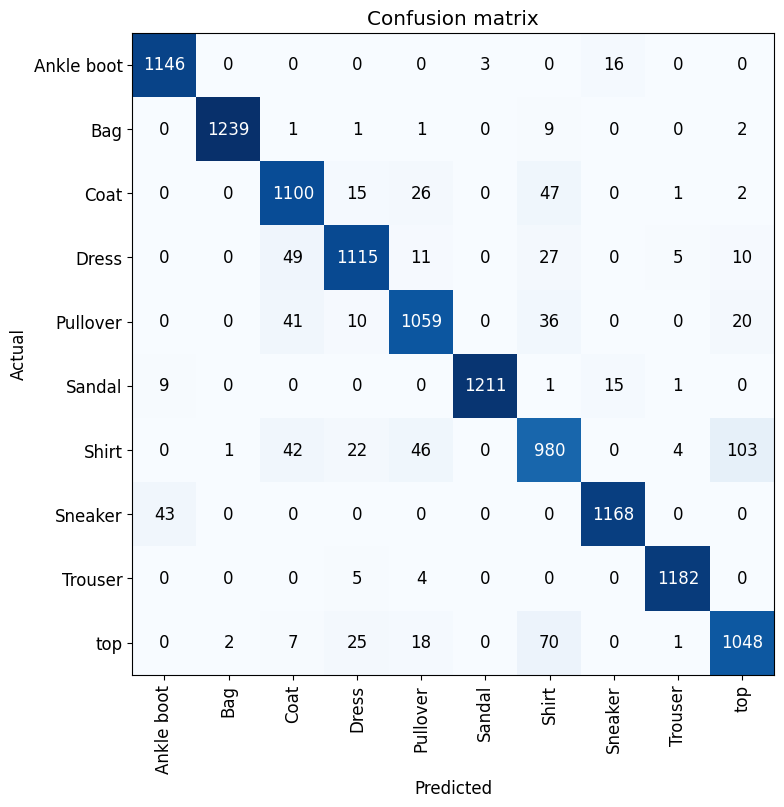

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=100)

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_original_v3.pkl')

# Apartado 2

## data destilation

In [ ]:
import random
import shutil
from pathlib import Path
import numpy as np
from PIL import Image

def media_arit(image_paths):
    avg_image = None
    count = 0
    # Sumar todas las imágenes (convertidas a array NumPy)
    for img_path in image_paths:
        with Image.open(img_path) as img:
            np_img = np.array(img, dtype=np.float32)
            if avg_image is None:
                avg_image = np_img
            else:
                avg_image += np_img
            count += 1
    # Calcular la media y convertir a uint8
    avg_image /= count
    avg_image = np.clip(avg_image, 0, 255).astype(np.uint8)
    return Image.fromarray(avg_image, mode='L')


In [ ]:
def create_distilled(src_path, dst_path, valid_ratio=0.2, fraction=0.2, mix_function=media_arit):
    """
    Genera un nuevo dataset a partir de la carpeta src_path.
    - Se crea una división: valid_ratio de las imágenes se destinan a validación (se copian sin modificar)
      y el resto (1 - valid_ratio) se destilan (agrupando imágenes según 'fraction').
    - Se espera que src_path tenga subcarpetas para cada clase.
    """
    src_path = Path(src_path)
    dst_path = Path(dst_path)

    # Si ya existe la carpeta destino, se elimina
    if dst_path.exists():
        shutil.rmtree(dst_path)
    dst_path.mkdir(parents=True, exist_ok=True)

    # Crear subcarpetas para training y validación
    train_dst = dst_path / "training"
    valid_dst = dst_path / "valid"
    train_dst.mkdir(parents=True, exist_ok=True)
    valid_dst.mkdir(parents=True, exist_ok=True)

    # Procesar cada carpeta de clase en src_path
    for class_dir in src_path.iterdir():
        if not class_dir.is_dir():
            continue

        if class_dir.name.lower() == "t-shirt":
            images = list(class_dir.glob('**/*.*'))
        else:
            images = list(class_dir.glob('*.*'))

        if len(images) == 0:
            continue

        # Crear directorios para la clase en training y valid
        new_train_class_dir = train_dst / class_dir.name
        new_train_class_dir.mkdir(parents=True, exist_ok=True)
        new_valid_class_dir = valid_dst / class_dir.name
        new_valid_class_dir.mkdir(parents=True, exist_ok=True)

        # Barajar para una división aleatoria
        random.shuffle(images)
        n_total = len(images)
        n_valid = int(n_total * valid_ratio)
        n_train = n_total - n_valid

        train_images = images[:n_train]
        valid_images = images[n_train:]

        # Para el training: destilamos usando el parámetro fraction
        if fraction == 0:  # Copiamos las imágenes originales
            for img_path in train_images:
                shutil.copy(img_path, new_train_class_dir)
        elif fraction == 1:  # Mezclamos todas las imágenes en una sola
            distilled_image = mix_function(train_images)
            distilled_filename = new_train_class_dir / "distilled.jpg"
            distilled_image.save(distilled_filename)
        else:
            group_size = max(1, int(len(train_images) * fraction))
            group_count = 0
            for i in range(0, len(train_images), group_size):
                group = train_images[i:i + group_size]
                distilled_image = mix_function(group)
                distilled_filename = new_train_class_dir / f"distilled_{group_count}.jpg"
                distilled_image.save(distilled_filename)
                group_count += 1

        # Para la validación: se copian las imágenes sin modificación
        for img_path in valid_images:
            shutil.copy(img_path, new_valid_class_dir)

In [ ]:
original_path = Path('/content/dataset/original/fashion_mnist/train')

mnist_001_path = base_path / "distilled_001"
mnist_001_path.mkdir(parents=True, exist_ok=True)

mnist_005_path = base_path / "distilled_005"
mnist_005_path.mkdir(parents=True, exist_ok=True)

mnist_0001_path = base_path / "distilled_0001"
mnist_0001_path.mkdir(parents=True, exist_ok=True)

In [ ]:
create_distilled(original_path, mnist_001_path, valid_ratio=0.01, fraction=0.01, mix_function=media_arit)

In [ ]:
create_distilled(original_path, mnist_005_path, valid_ratio=0.005, fraction=0.05, mix_function=media_arit)

In [ ]:
create_distilled(original_path, mnist_0001_path, valid_ratio=0.1, fraction=0.001, mix_function=media_arit)

## Lenet 001

In [ ]:
dst = base_path / "distilled_001"

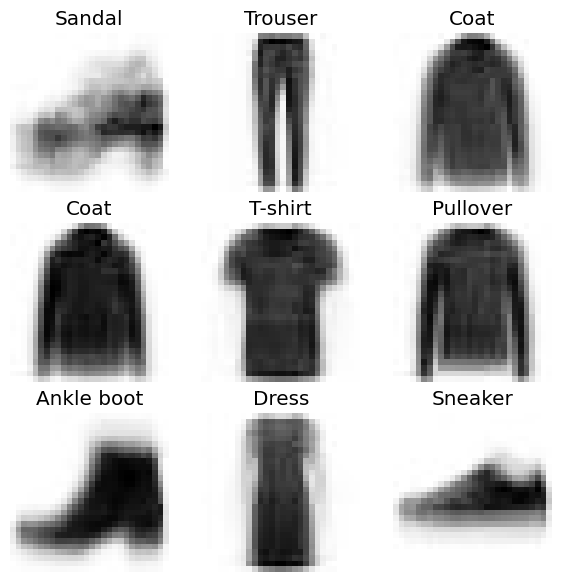

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

Número total de imágenes en entrenamiento: 1010
Número total de imágenes en validación: 600

Clases: ['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'T-shirt', 'Trouser']


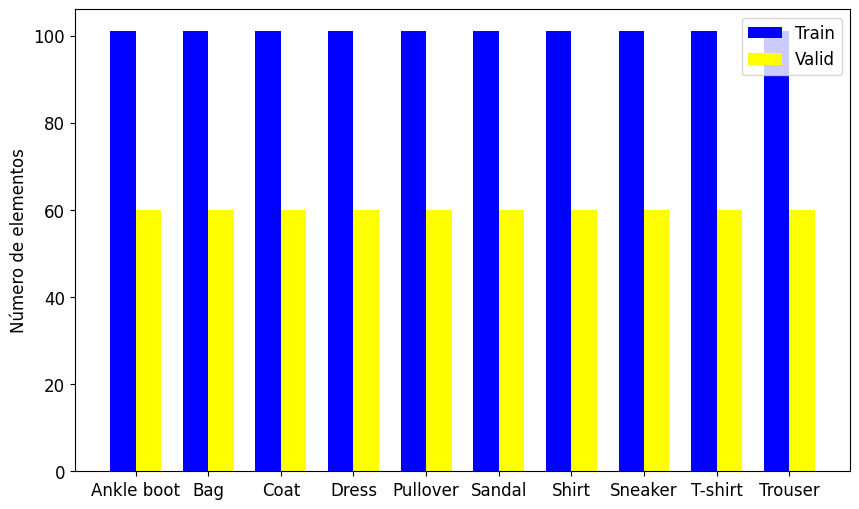

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])


In [ ]:
start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 4: early stopping

Tiempo de entrenamiento: 15.92 segundos


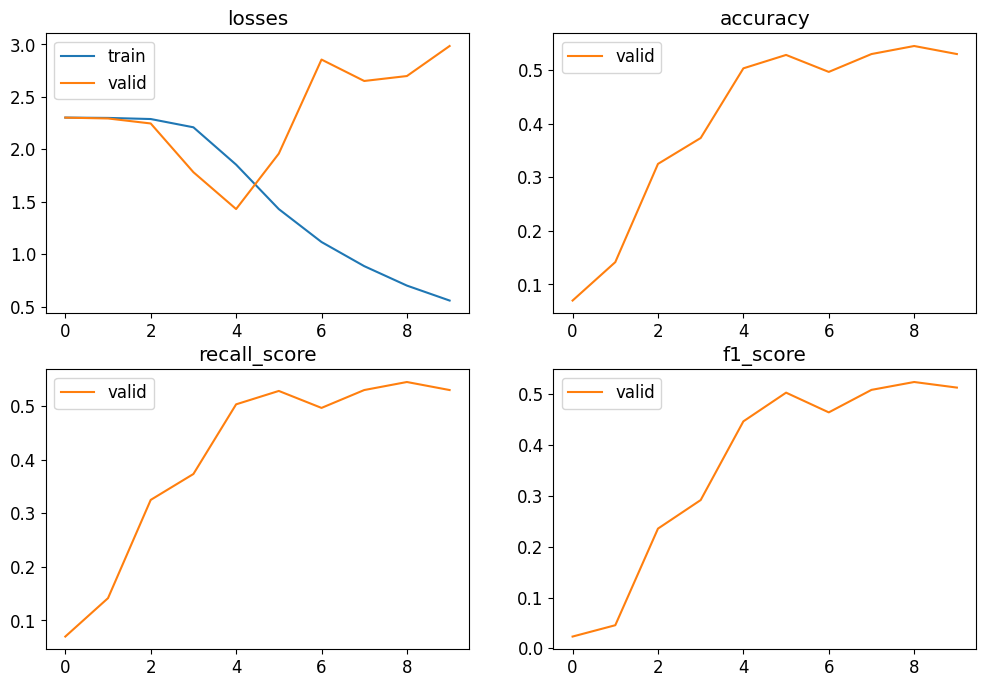

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 2.9852
Accuracy: 0.5300
Recall: 0.5300
F1-Score: 0.5130


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_v3.pkl')

## lenet 005

In [ ]:
dst = base_path / "distilled_005"

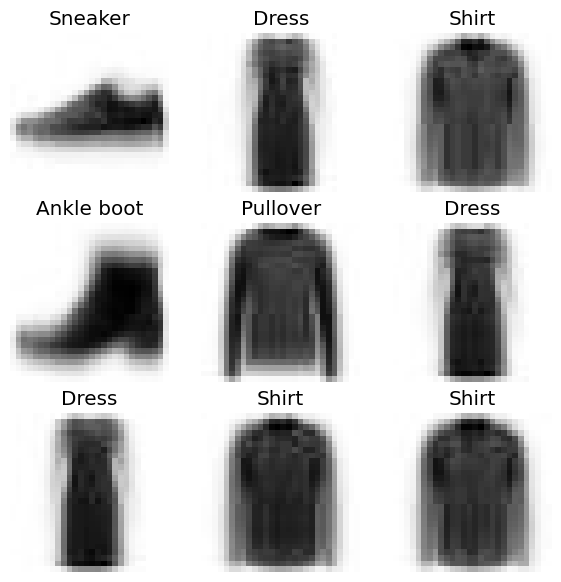

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

Número total de imágenes en entrenamiento: 210
Número total de imágenes en validación: 300

Clases: ['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'T-shirt', 'Trouser']


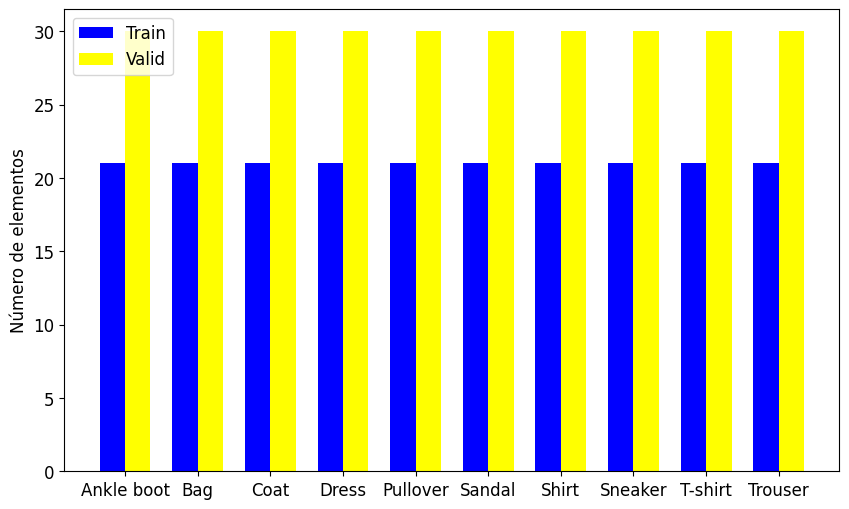

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])


In [ ]:
start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 21: early stopping

Tiempo de entrenamiento: 19.36 segundos


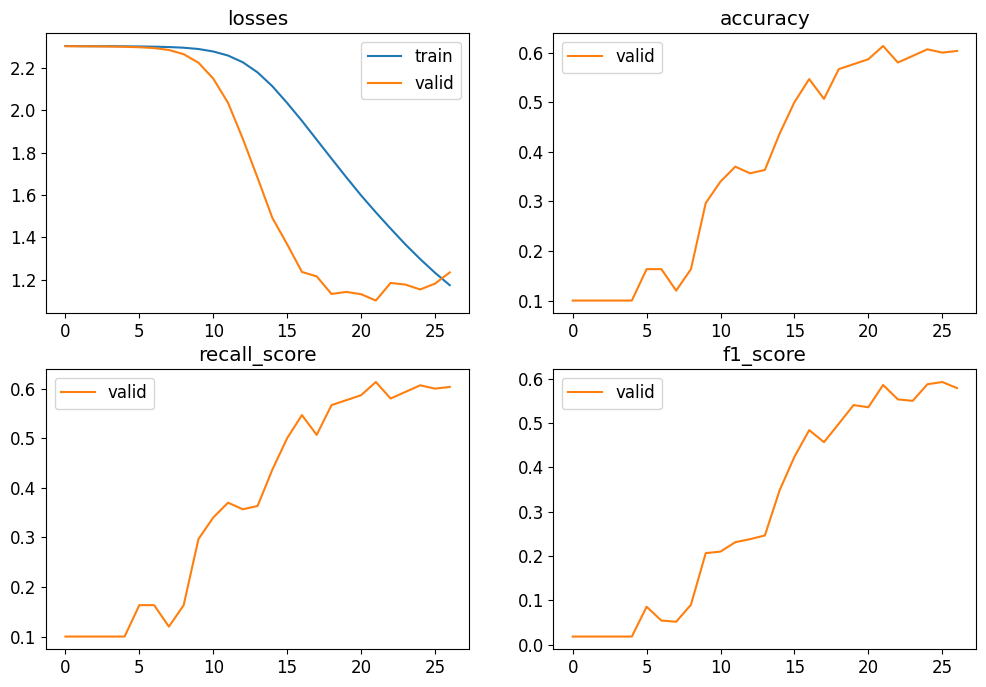

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.2338
Accuracy: 0.6033
Recall: 0.6033
F1-Score: 0.5785


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_v3.pkl')

## Lenet 0001

In [ ]:
dst = base_path / "distilled_0001"

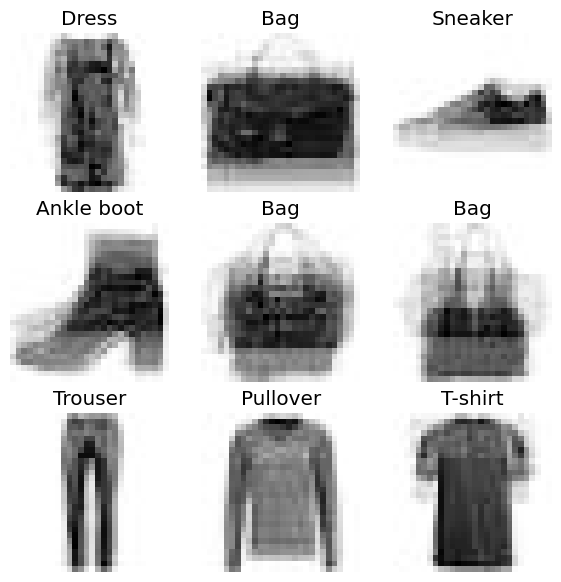

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

Número total de imágenes en entrenamiento: 10800
Número total de imágenes en validación: 6000

Clases: ['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'T-shirt', 'Trouser']


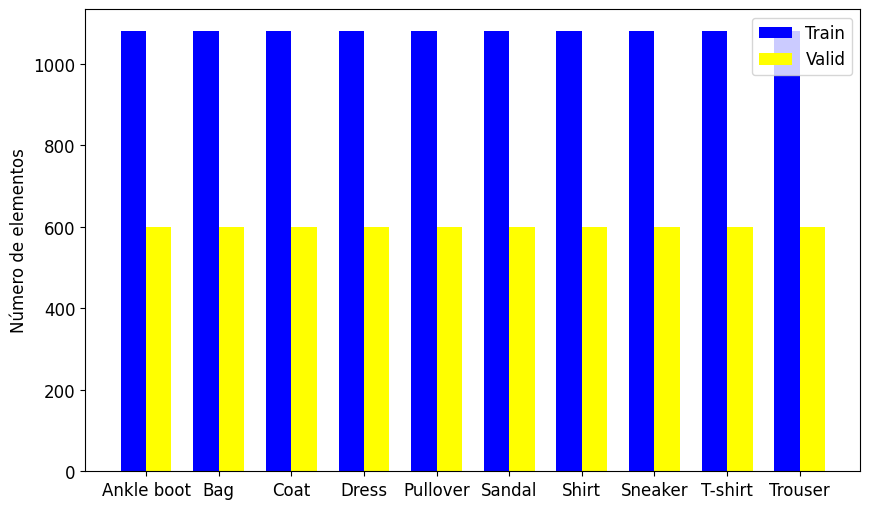

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])


In [ ]:
start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 1: early stopping

Tiempo de entrenamiento: 106.27 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.4401
Accuracy: 0.7142
Recall: 0.7142
F1-Score: 0.7116


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_v3.pkl')

## Resnet 001

In [ ]:
dst = base_path / "distilled_001"

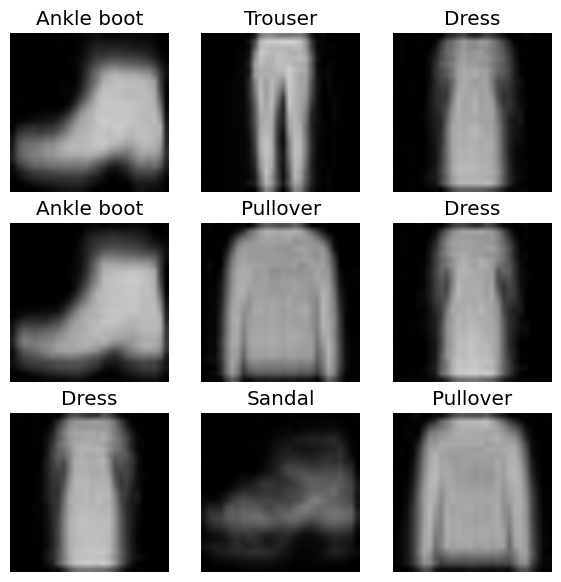

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])
learn.summary()

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                      

In [ ]:
start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 0: early stopping

Tiempo de entrenamiento: 34.34 segundos


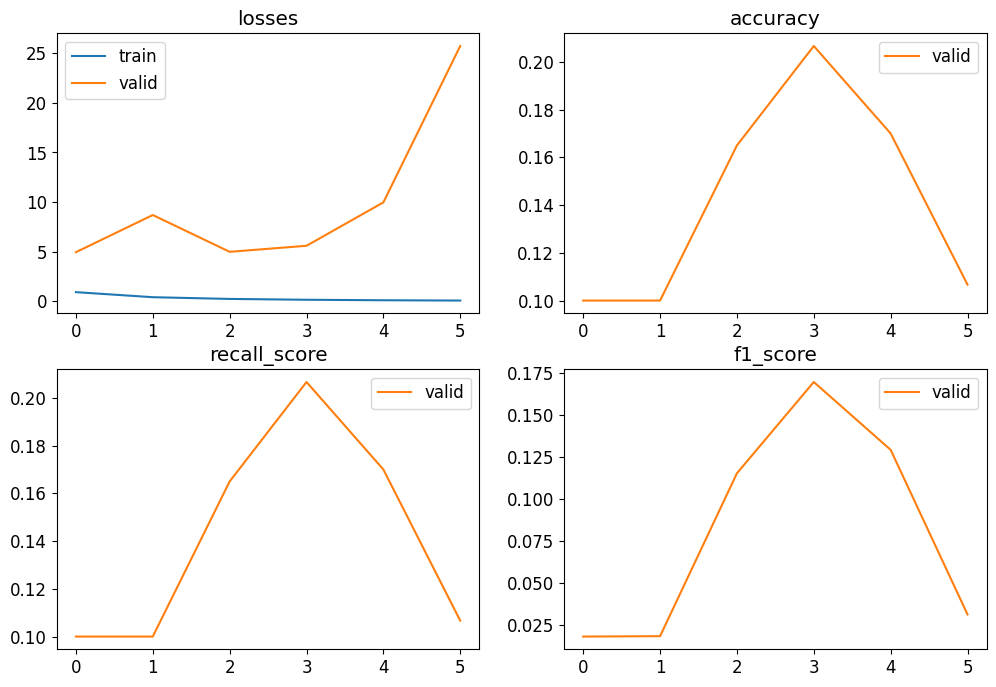

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 25.7304
Accuracy: 0.1067
Recall: 0.1067
F1-Score: 0.0313


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_v3.pkl')

## Resnet 005

In [ ]:
dst = base_path / "distilled_005"

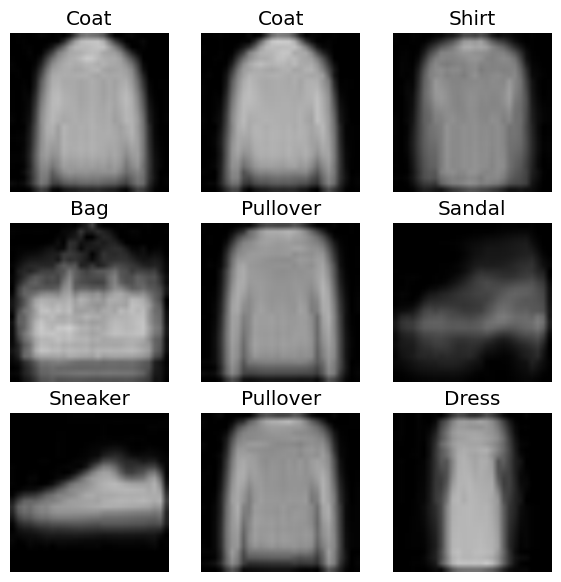

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])


In [ ]:
start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 0: early stopping

Tiempo de entrenamiento: 12.34 segundos


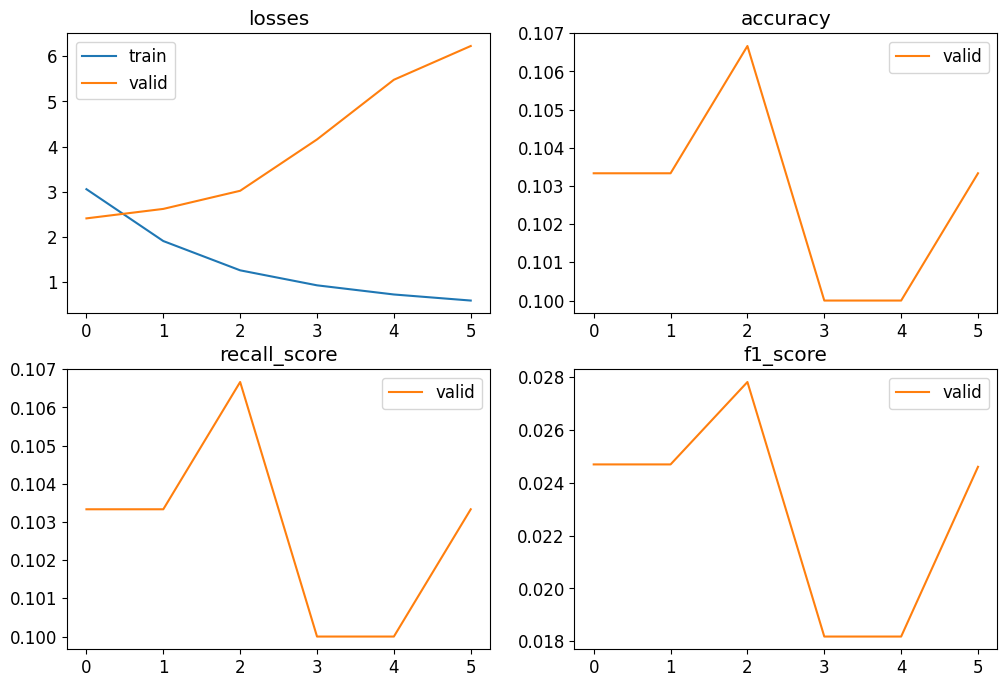

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 6.2286
Accuracy: 0.1033
Recall: 0.1033
F1-Score: 0.0246


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_v3.pkl')

## Resnet 0001

In [ ]:
dst = base_path / "distilled_0001"

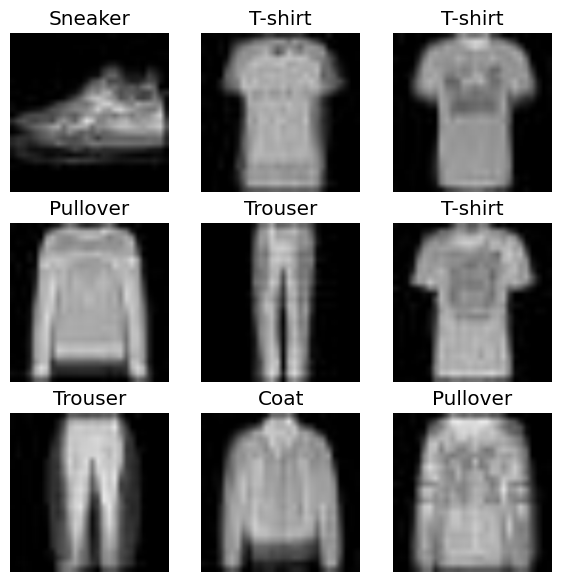

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])


In [ ]:
start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 13: early stopping

Tiempo de entrenamiento: 1035.06 segundos


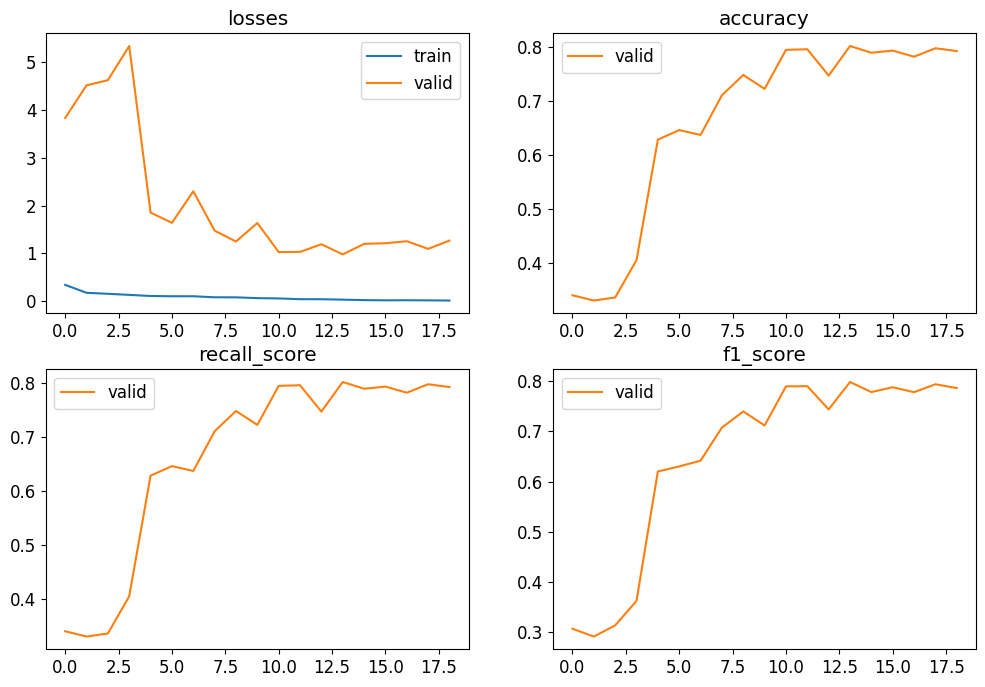

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.2673
Accuracy: 0.7928
Recall: 0.7928
F1-Score: 0.7865


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_v3.pkl')

# Apartado 3

## Seleccion de ejemplos

In [ ]:
import random
def get_items_fraction(path, train_fraction=0.8):
    all_items = get_image_files(path)
    selected = []
    for item in all_items:
        if item.parts[-3].lower() == 'training':
            if random.random() < train_fraction:
                selected.append(item)
        else:
            selected.append(item)
    return selected

In [7]:
import random
def get_items_fraction2(path, train_fraction=0.8):
    all_items = get_image_files(path)
    selected = []
    for item in all_items:
        if item.parts[-3].lower() == 'train':
            if random.random() < train_fraction:
                selected.append(item)
        else:
            selected.append(item)
    return selected

## Base - Lenet

Example 1

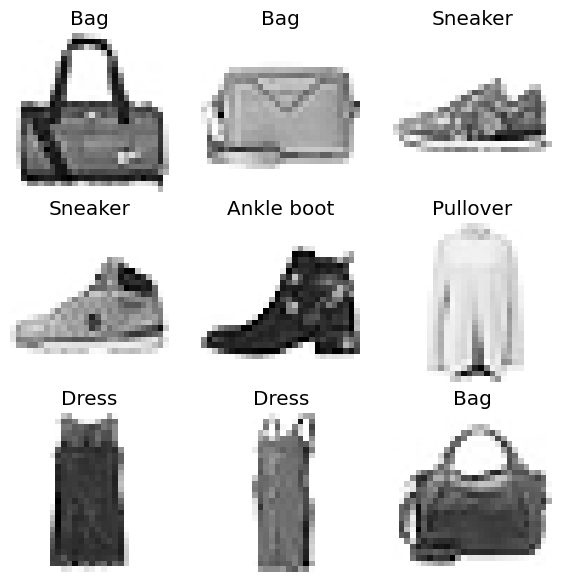

In [16]:
# Crear los DataLoaders
blocks = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction2(p, train_fraction=0.8),
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.2)
)

# Crear los DataLoaders
dls = blocks.dataloaders(dataset_root, bs=64)

# Mostrar una muestra de las imágenes para verificar la correcta organización
dls.show_batch(max_n=9, figsize=(7,7))


Número total de imágenes en entrenamiento: 39228
Número total de imágenes en validación: 9806

Clases: ['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'Trouser', 'top']


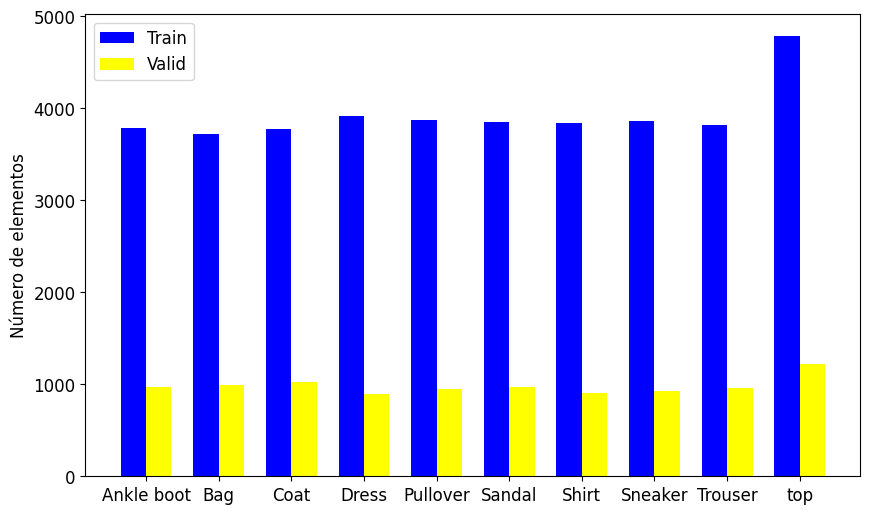

In [17]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [20]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])


In [21]:
start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")


Tiempo de entrenamiento: 743.34 segundos


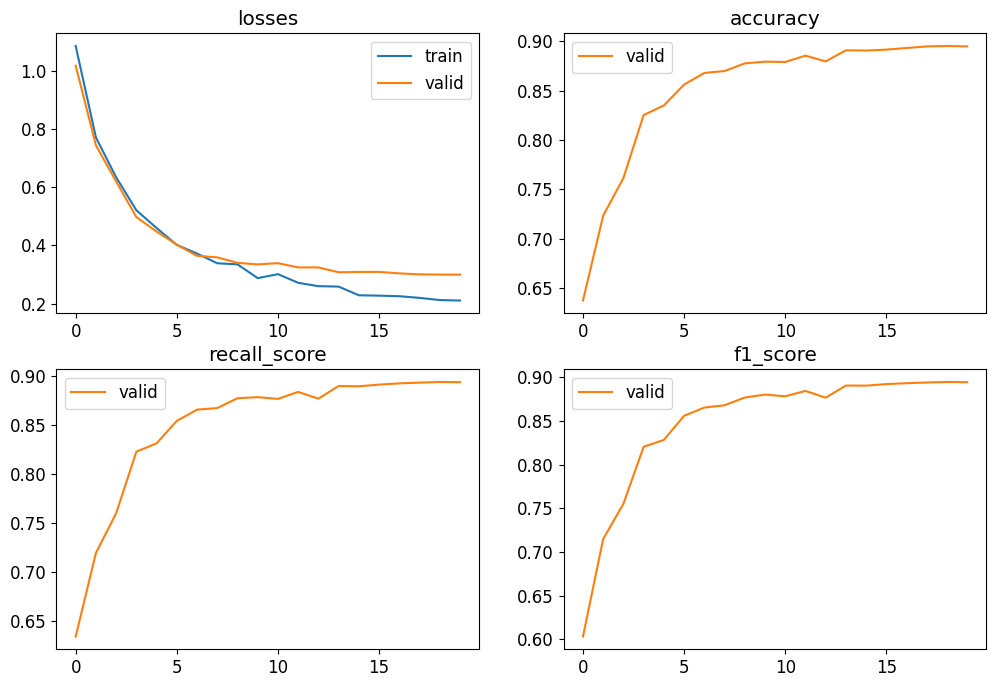

In [22]:
learn.recorder.plot_metrics()

In [23]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.2995
Accuracy: 0.8949
Recall: 0.8940
F1-Score: 0.8942


In [24]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_5cluster01_v3.pkl')

## Lenet 001

In [ ]:
dst = base_path / "distilled_001"

Ejemplo 1

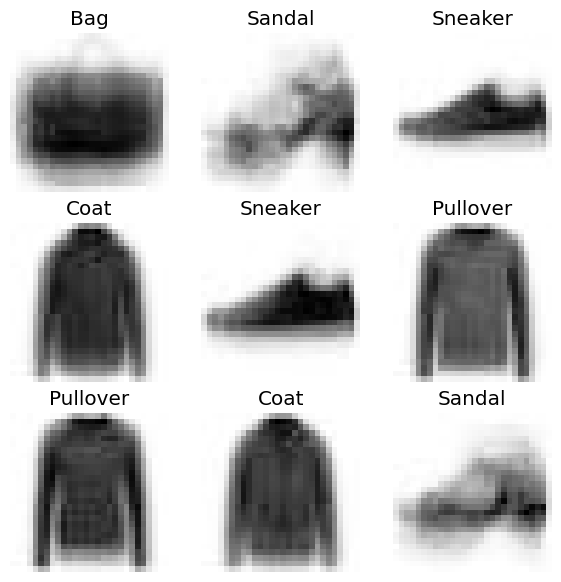

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

Número total de imágenes en entrenamiento: 828
Número total de imágenes en validación: 600

Clases: ['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'T-shirt', 'Trouser']


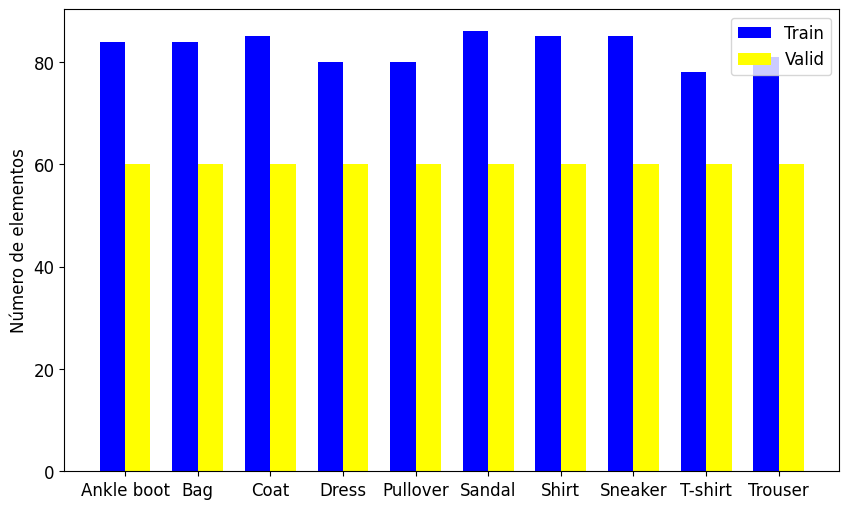

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])


In [ ]:
start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 4: early stopping

Tiempo de entrenamiento: 12.62 segundos


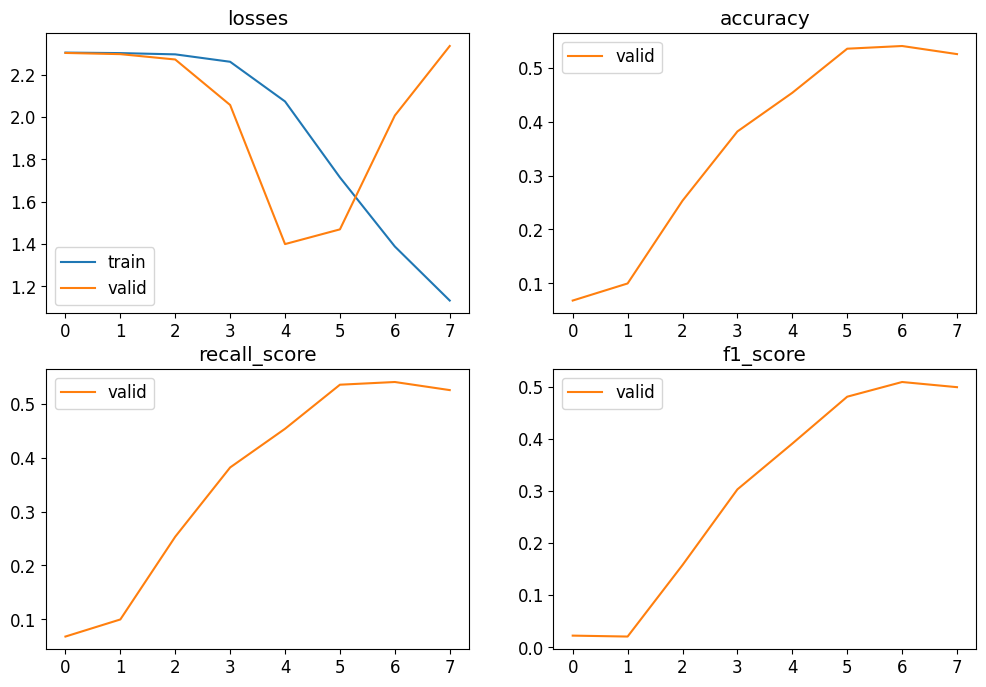

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 2.3360
Accuracy: 0.5250
Recall: 0.5250
F1-Score: 0.4994


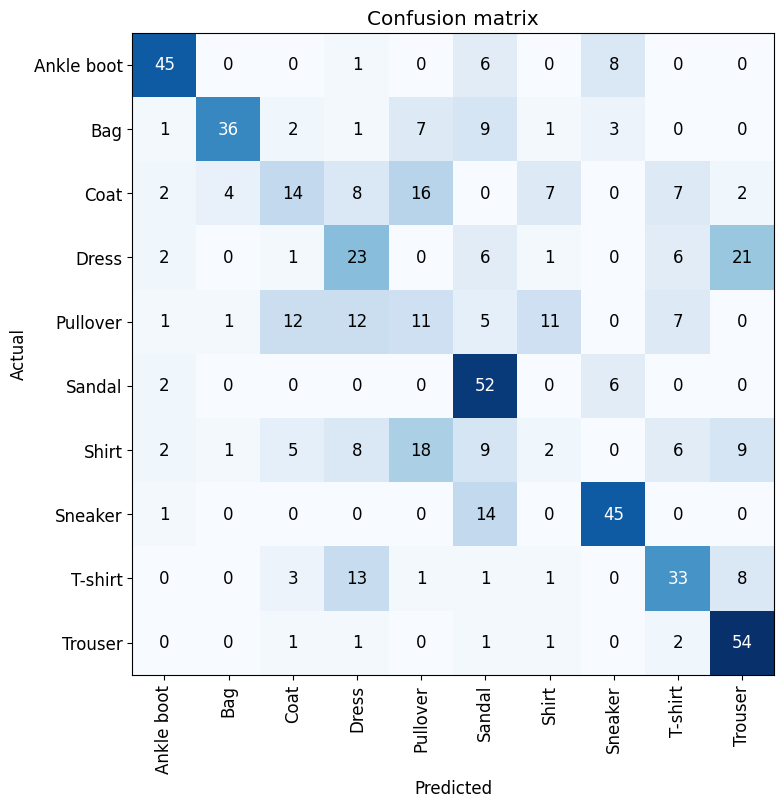

In [ ]:
#Creamos la interpretación de nuestro learner
interp = ClassificationInterpretation.from_learner(learn)

#Visualizamos la matriz de confusión
interp.plot_confusion_matrix(figsize=(8,8), dpi=100)

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_5cluster01_v3.pkl')

Ejemplo 2

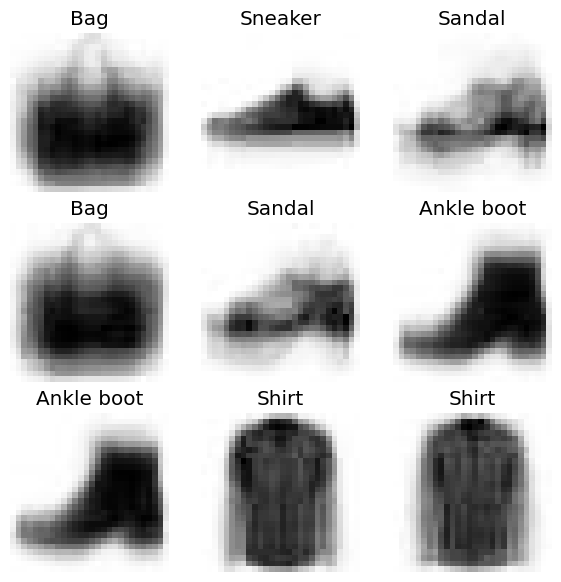

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 5: early stopping

Tiempo de entrenamiento: 13.91 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.7029
Accuracy: 0.5467
Recall: 0.5467
F1-Score: 0.5211


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_5cluster02_v3.pkl')

Ejemplo 3

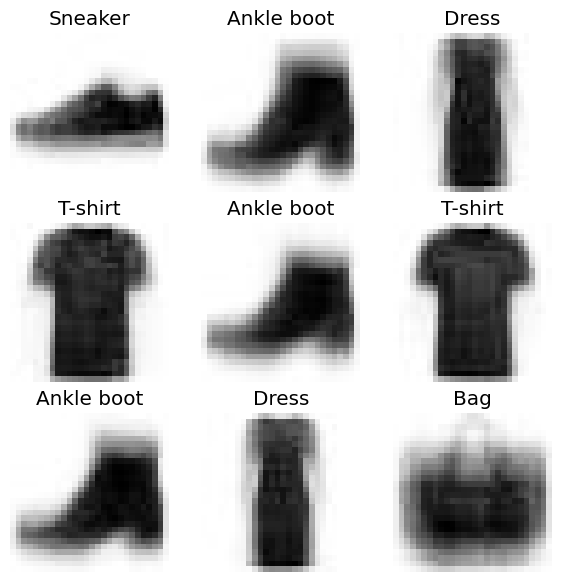

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 5: early stopping

Tiempo de entrenamiento: 14.30 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.9232
Accuracy: 0.6050
Recall: 0.6050
F1-Score: 0.5889


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_5cluster03_v3.pkl')

Ejemplo 4

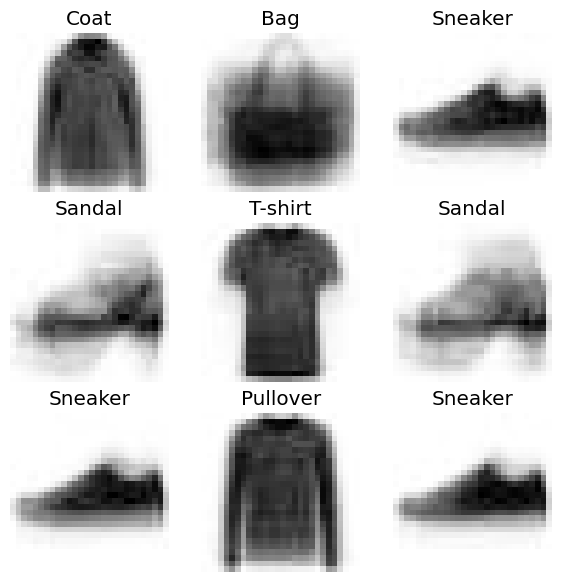

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 4: early stopping

Tiempo de entrenamiento: 17.02 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.7635
Accuracy: 0.5733
Recall: 0.5733
F1-Score: 0.5507


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_5cluster04_v3.pkl')

Ejemplo 5

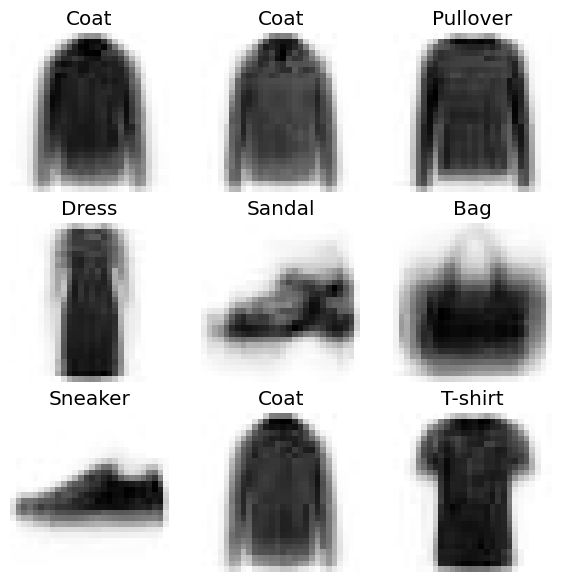

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 4: early stopping

Tiempo de entrenamiento: 17.30 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 3.8136
Accuracy: 0.4800
Recall: 0.4800
F1-Score: 0.4570


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_5cluster05_v3.pkl')

## Lenet 005

In [ ]:
dst = base_path / "distilled_005"

Ejemplo 1

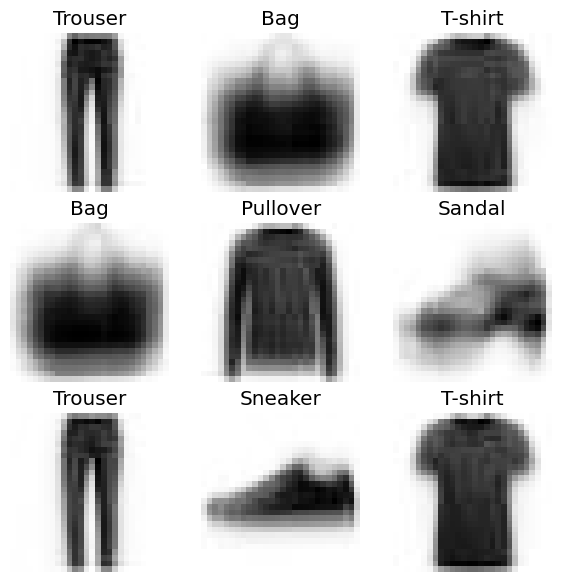

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))


Número total de imágenes en entrenamiento: 172
Número total de imágenes en validación: 300

Clases: ['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'T-shirt', 'Trouser']


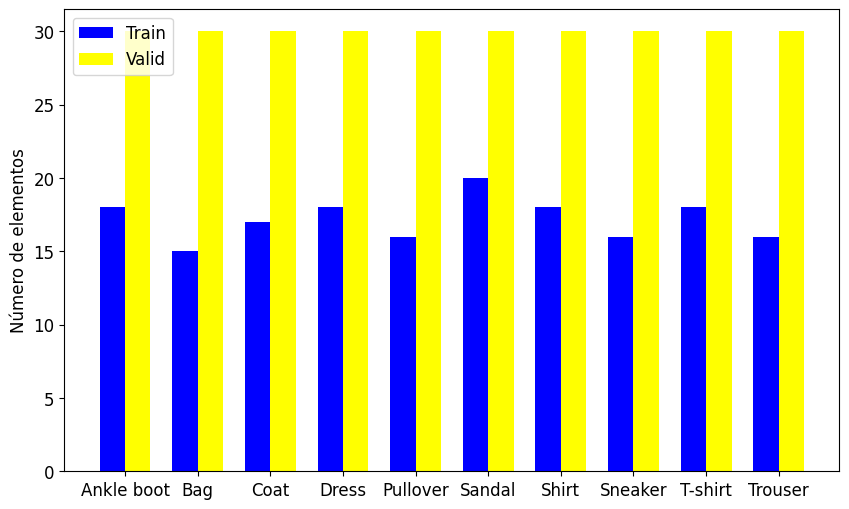

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])


In [ ]:
start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")


Tiempo de entrenamiento: 28.56 segundos


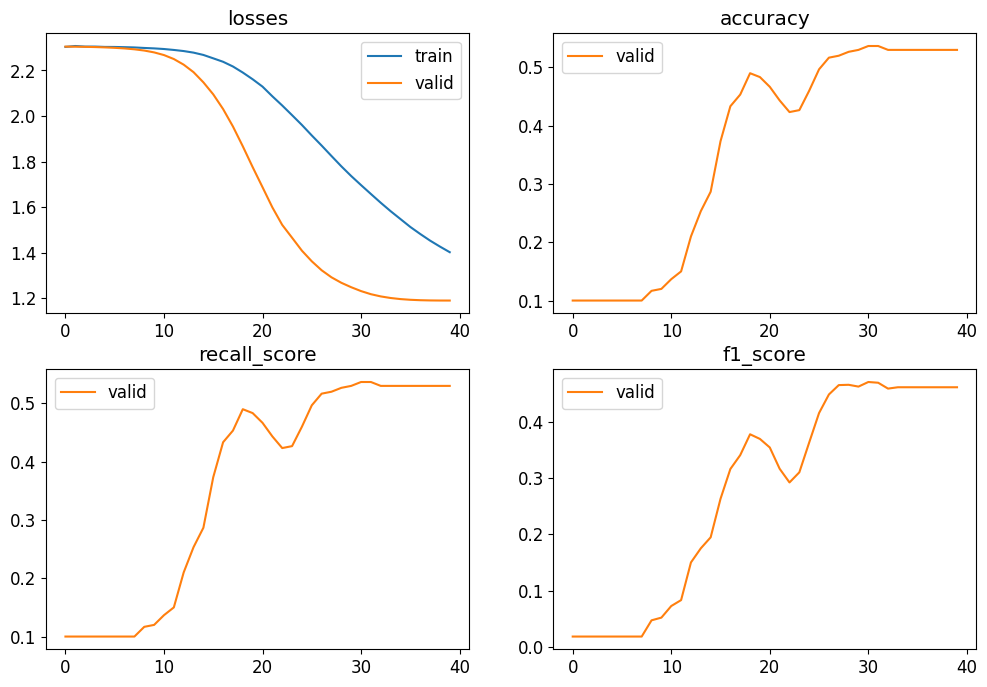

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.1902
Accuracy: 0.5300
Recall: 0.5300
F1-Score: 0.4615


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_5cluster01_v3.pkl')

Example 2

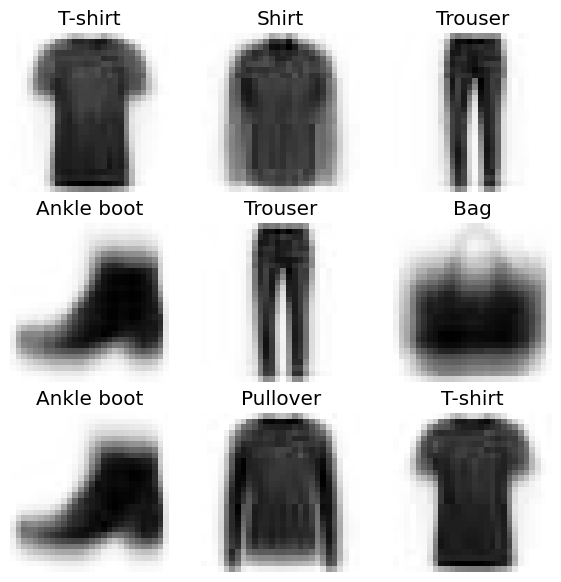

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))


In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")


Tiempo de entrenamiento: 44.16 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.2006
Accuracy: 0.5567
Recall: 0.5567
F1-Score: 0.4970


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_5cluster02_v3.pkl')

Example 3

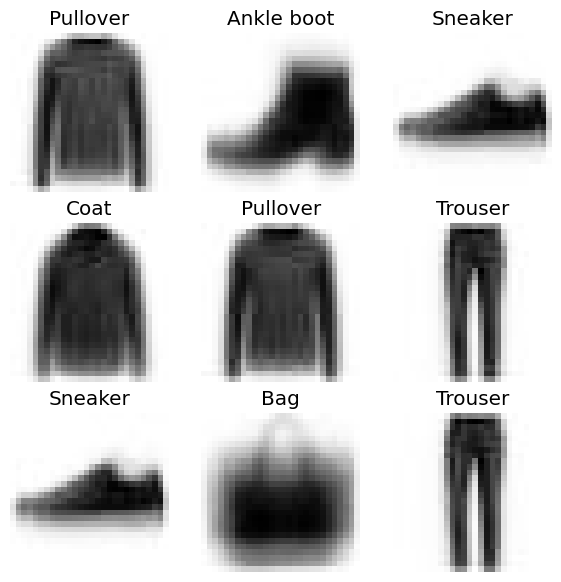

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))


In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 33: early stopping

Tiempo de entrenamiento: 35.15 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.9903
Accuracy: 0.6567
Recall: 0.6567
F1-Score: 0.6387


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_5cluster03_v3.pkl')

Example 4

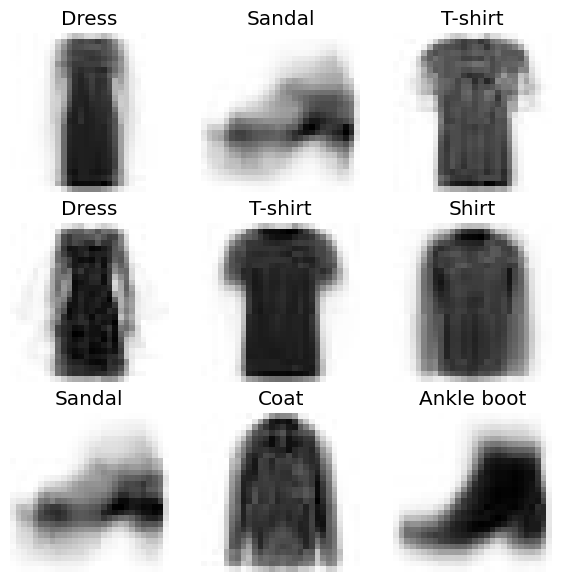

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))


In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 27: early stopping

Tiempo de entrenamiento: 26.31 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.0825
Accuracy: 0.6133
Recall: 0.6133
F1-Score: 0.5975


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_5cluster04_v3.pkl')

Example 5

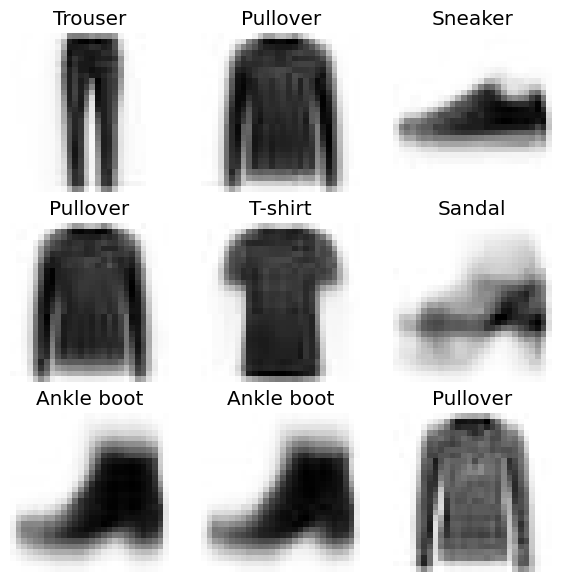

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))


In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 27: early stopping

Tiempo de entrenamiento: 29.09 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.1177
Accuracy: 0.5767
Recall: 0.5767
F1-Score: 0.5316


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_5cluster05_v3.pkl')

## Lenet 0001

In [ ]:
dst = base_path / "distilled_0001"

Example 1

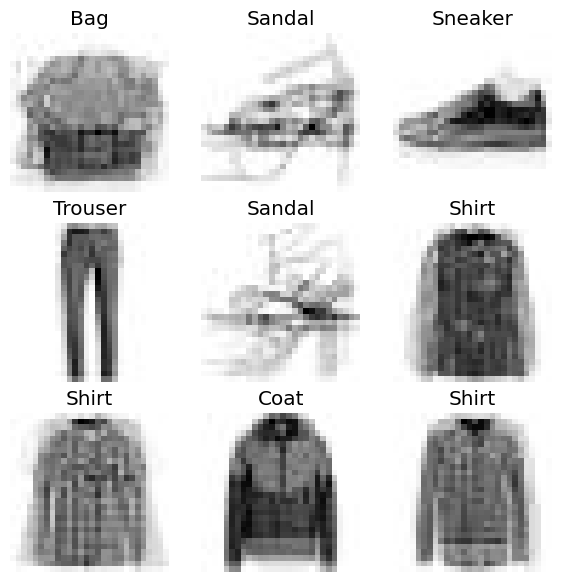

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))


Número total de imágenes en entrenamiento: 8636
Número total de imágenes en validación: 6000

Clases: ['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'T-shirt', 'Trouser']


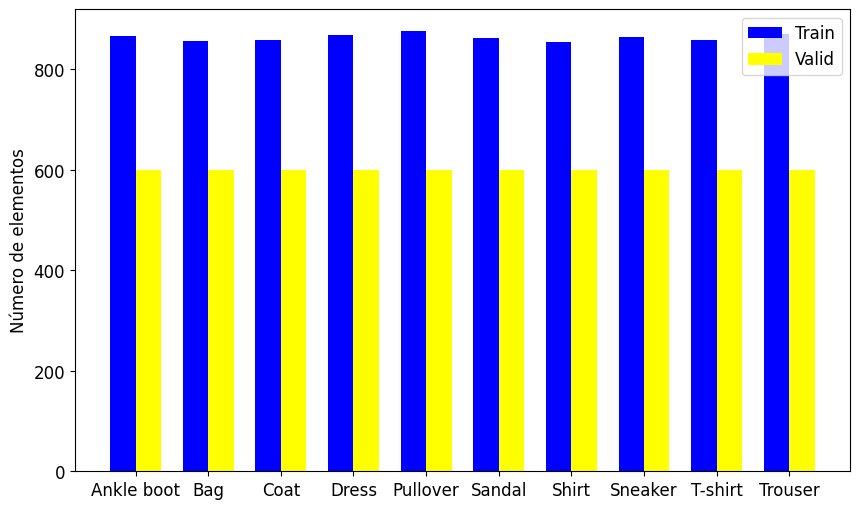

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 2: early stopping

Tiempo de entrenamiento: 190.05 segundos


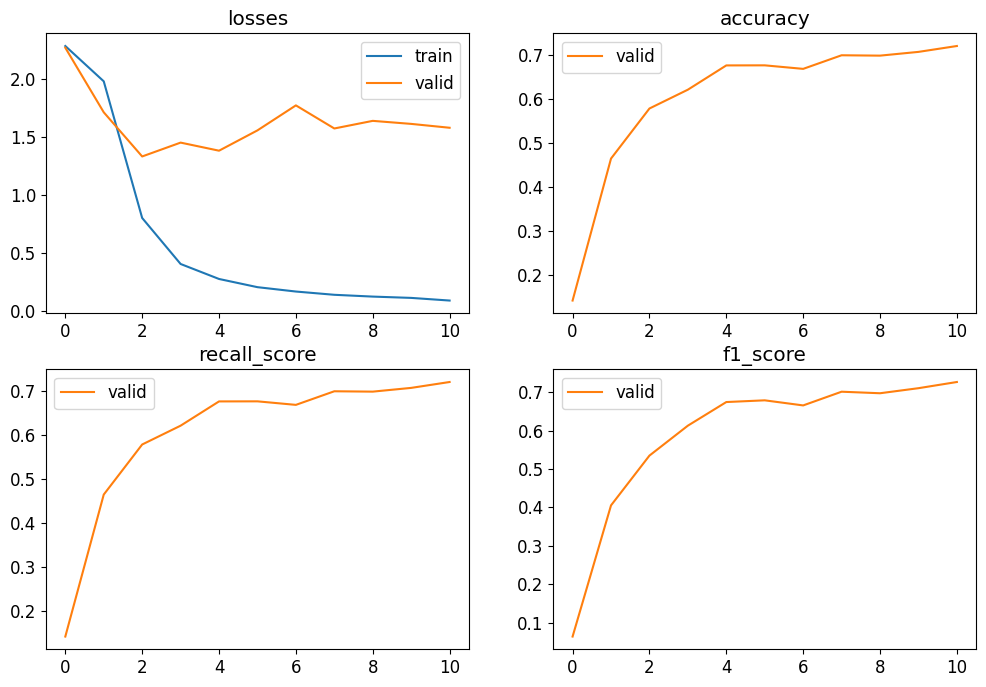

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.5803
Accuracy: 0.7200
Recall: 0.7200
F1-Score: 0.7264


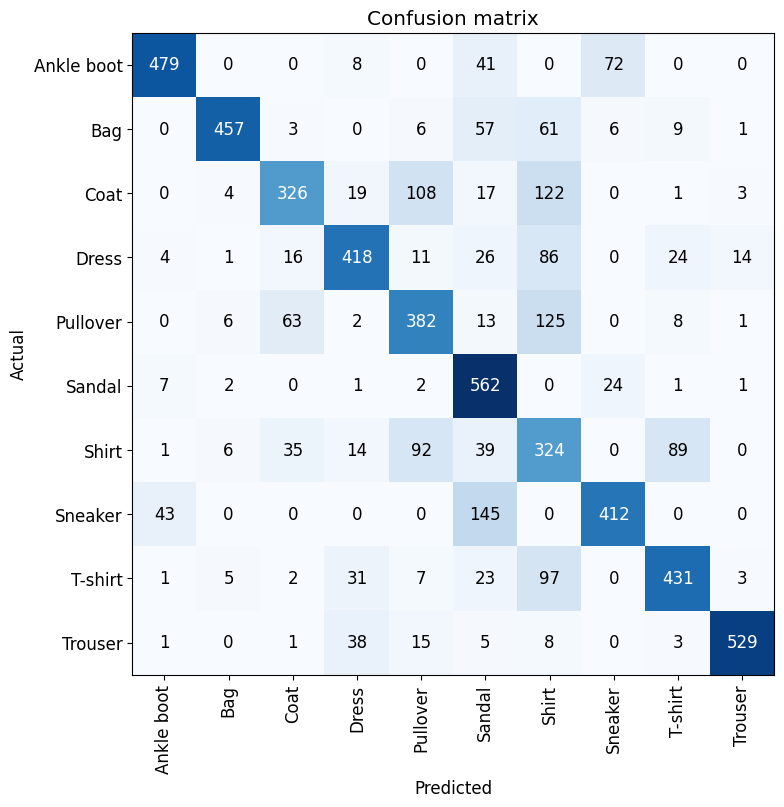

In [ ]:
#Creamos la interpretación de nuestro learner
interp = ClassificationInterpretation.from_learner(learn)

#Visualizamos la matriz de confusión
interp.plot_confusion_matrix(figsize=(8,8), dpi=100)

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_5cluster01_v3.pkl')

Example 2

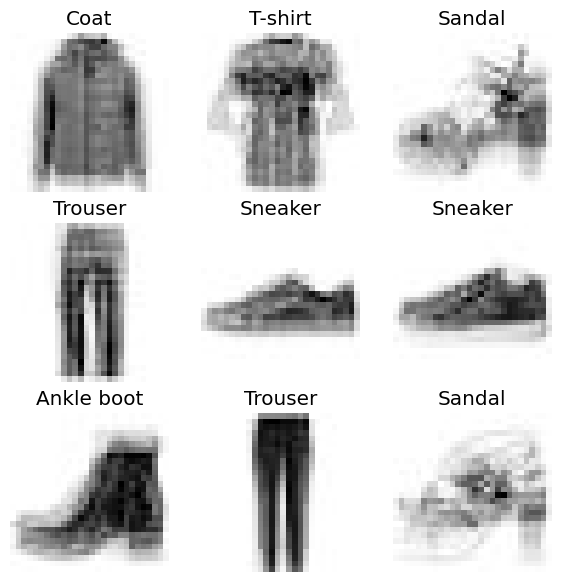

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))


In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 2: early stopping

Tiempo de entrenamiento: 189.84 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.3678
Accuracy: 0.7080
Recall: 0.7080
F1-Score: 0.7053


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_5cluster02_v3.pkl')

Example 3

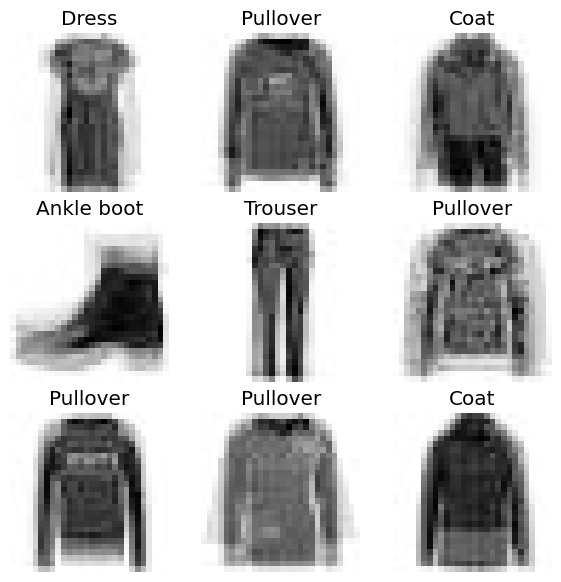

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))


In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 2: early stopping

Tiempo de entrenamiento: 179.01 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.5062
Accuracy: 0.7067
Recall: 0.7067
F1-Score: 0.7105


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_5cluster03_v3.pkl')

Example 4

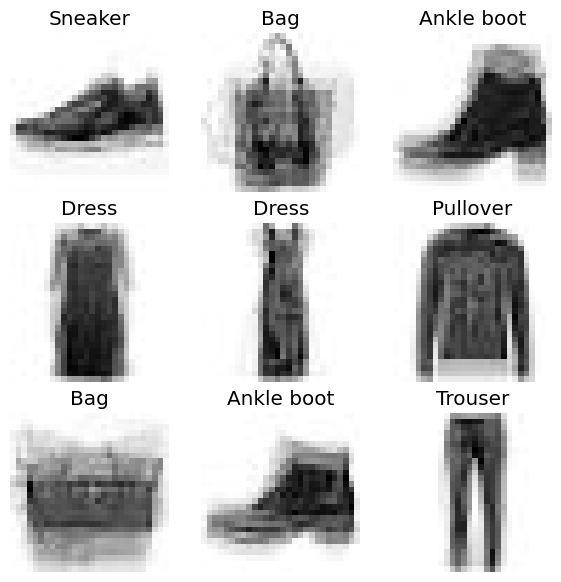

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))


In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 2: early stopping

Tiempo de entrenamiento: 129.28 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.1905
Accuracy: 0.7403
Recall: 0.7403
F1-Score: 0.7426


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_5cluster04_v3.pkl')

Example 5

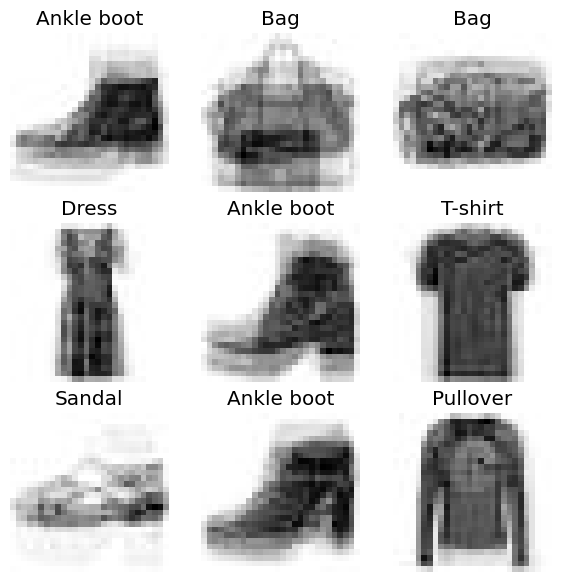

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))


In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 2: early stopping

Tiempo de entrenamiento: 125.59 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.4351
Accuracy: 0.7055
Recall: 0.7055
F1-Score: 0.7065


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_5cluster05_v3.pkl')

## Base - Resnet

Example 1

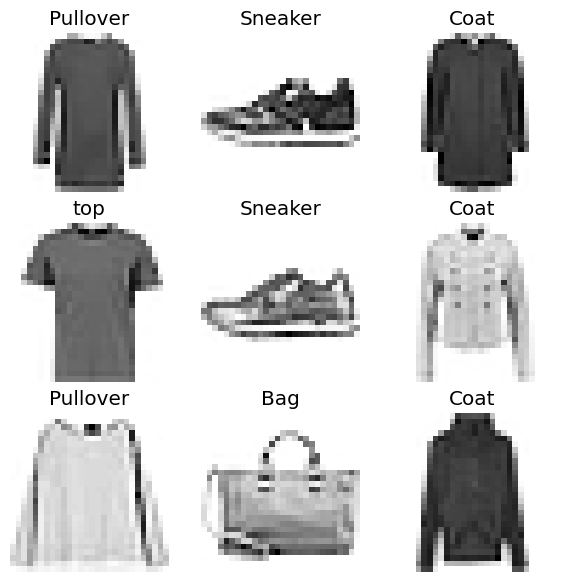

In [10]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction2(p, train_fraction=0.8),
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = blocks.dataloaders(dataset_root, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [11]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

Número total de imágenes en entrenamiento: 39310
Número total de imágenes en validación: 9827

Clases: ['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'Trouser', 'top']


In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 8: early stopping

Tiempo de entrenamiento: 2861.63 segundos


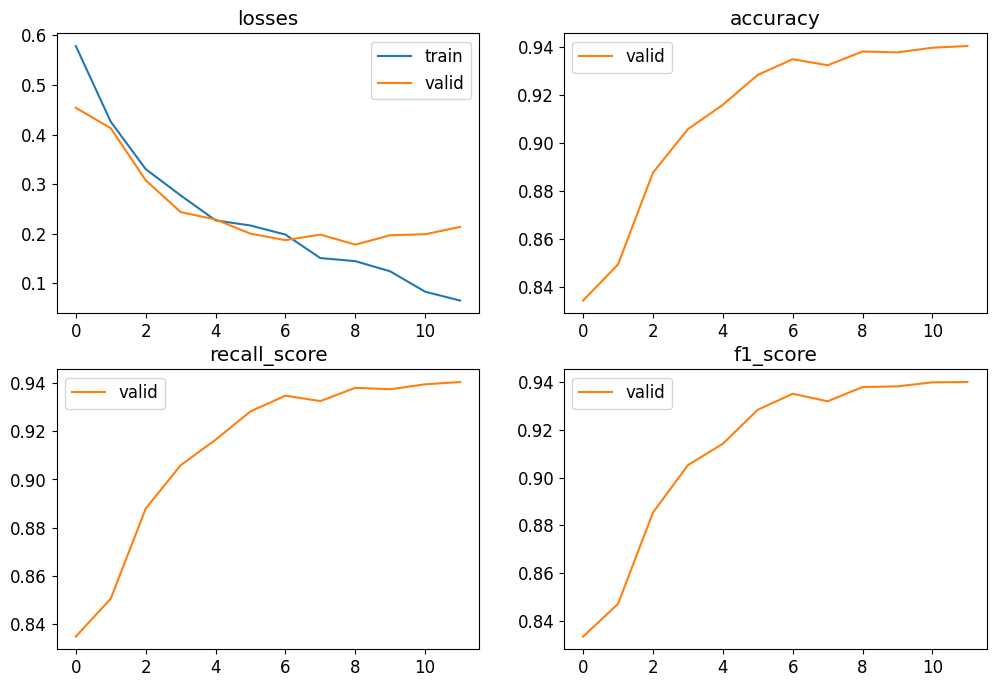

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.2136
Accuracy: 0.9402
Recall: 0.9406
F1-Score: 0.9399


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_5cluster01_v3.pkl')

## Resnet 001

In [ ]:
dst = base_path / "distilled_001"

Example 1

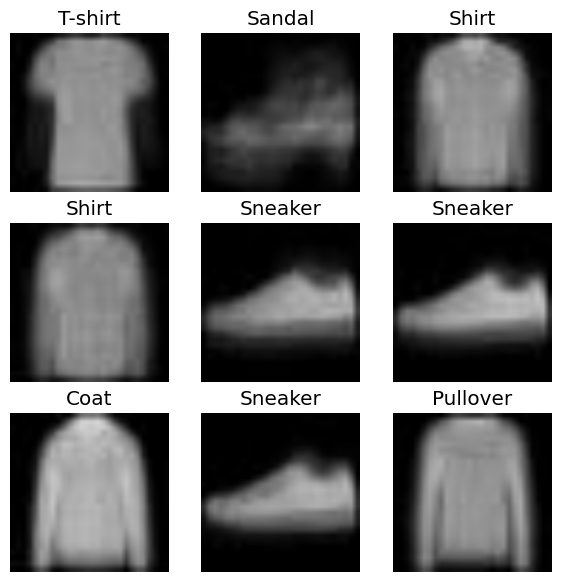

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

Número total de imágenes en entrenamiento: 820
Número total de imágenes en validación: 600

Clases: ['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'T-shirt', 'Trouser']


In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 0: early stopping

Tiempo de entrenamiento: 19.83 segundos


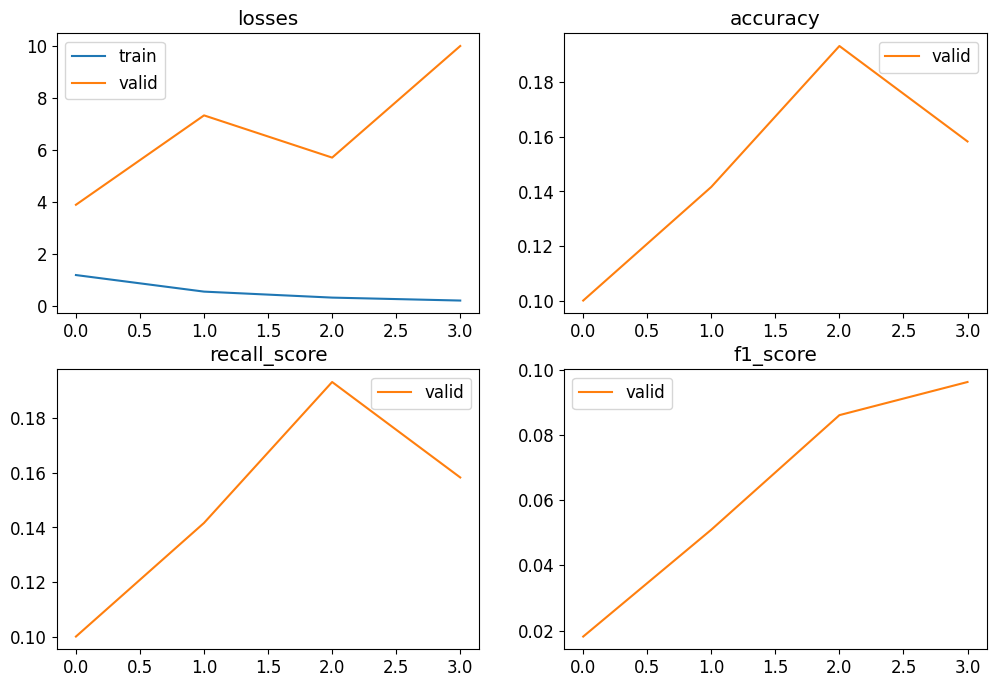

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 10.0111
Accuracy: 0.1583
Recall: 0.1583
F1-Score: 0.0963


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_5cluster01_v3.pkl')

Example 2

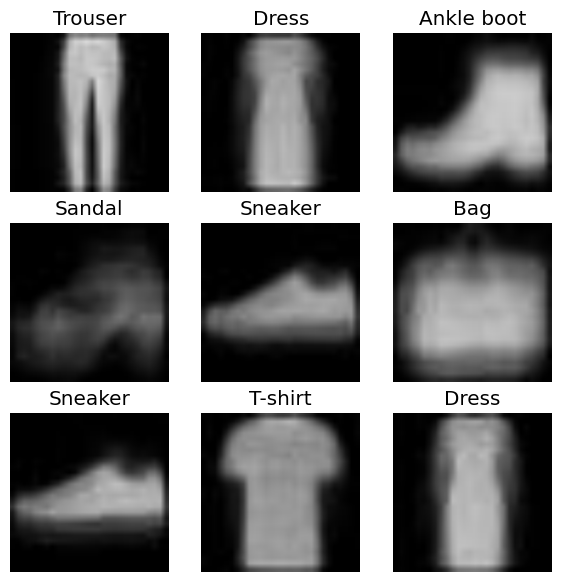

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(30)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 0: early stopping

Tiempo de entrenamiento: 19.02 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 4.1546
Accuracy: 0.1917
Recall: 0.1917
F1-Score: 0.1508


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_5cluster02_v3.pkl')

Example 3

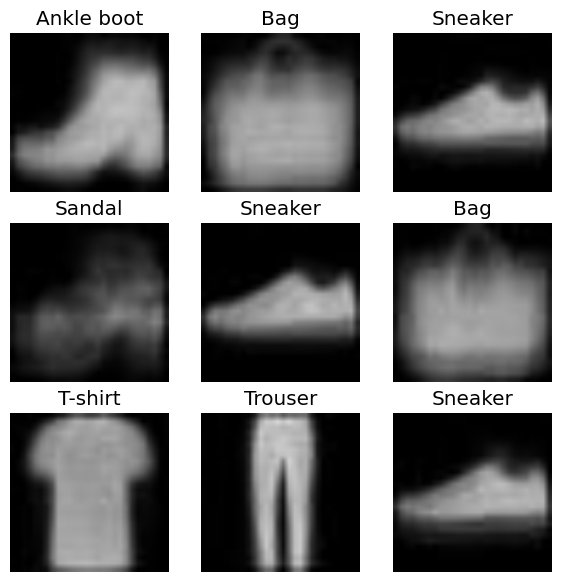

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 0: early stopping

Tiempo de entrenamiento: 19.39 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 4.8125
Accuracy: 0.1767
Recall: 0.1767
F1-Score: 0.0906


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_5cluster03_v3.pkl')

## Resnet 005

In [ ]:
dst = base_path / "distilled_005"

Example 1

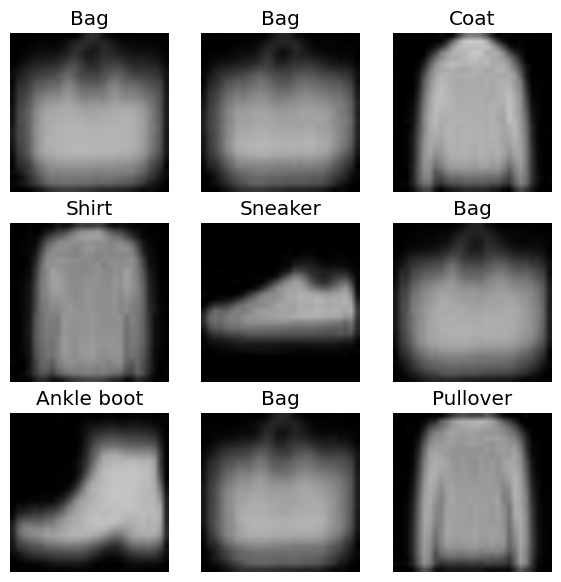

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

Número total de imágenes en entrenamiento: 171
Número total de imágenes en validación: 300

Clases: ['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'T-shirt', 'Trouser']


In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 0: early stopping

Tiempo de entrenamiento: 7.94 segundos


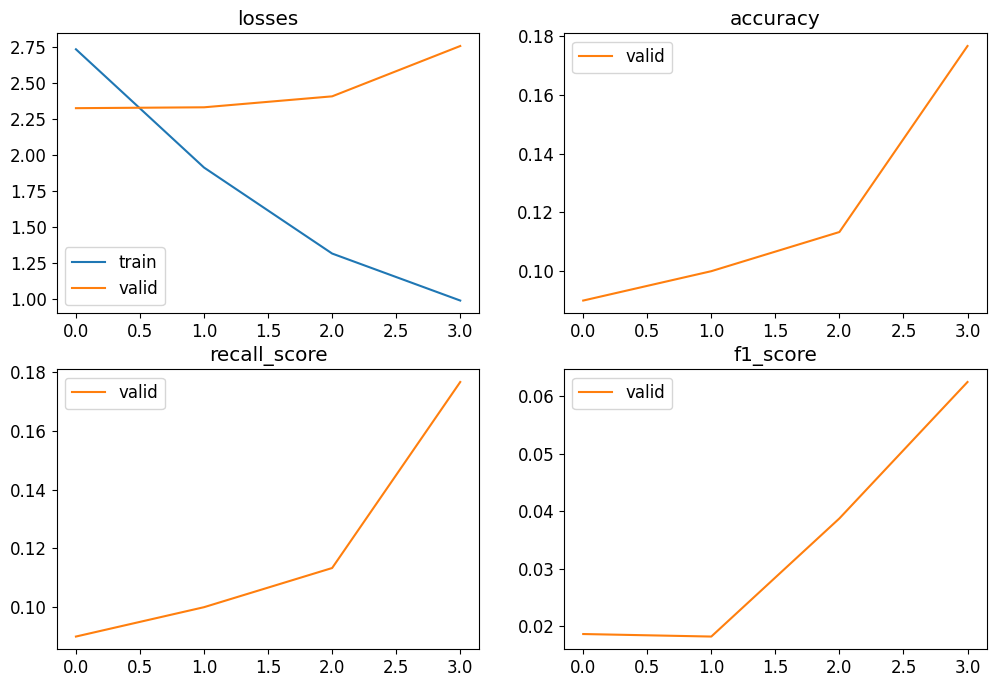

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 2.7584
Accuracy: 0.1767
Recall: 0.1767
F1-Score: 0.0625


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_5cluster01_v3.pkl')

Example 2

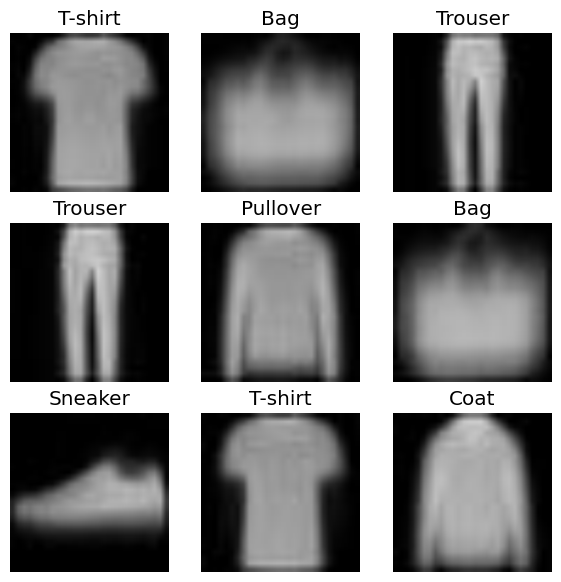

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 0: early stopping

Tiempo de entrenamiento: 6.43 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 3.0510
Accuracy: 0.1633
Recall: 0.1633
F1-Score: 0.0559


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_5cluster02_v3.pkl')

Example 3

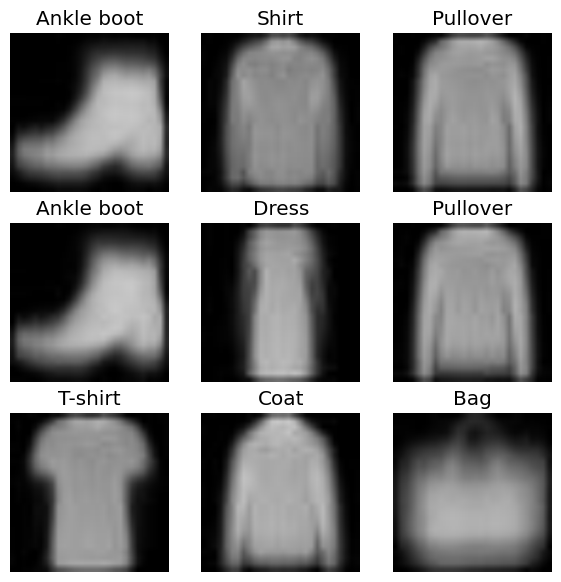

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 0: early stopping

Tiempo de entrenamiento: 7.40 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 3.8537
Accuracy: 0.1000
Recall: 0.1000
F1-Score: 0.0182


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_5cluster03_v3.pkl')

## Resnet 0001

In [ ]:
dst = base_path / "distilled_0001"

Example 1

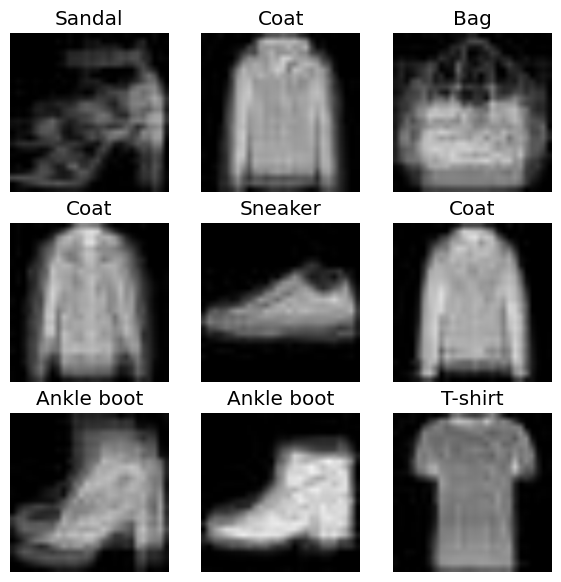

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

Número total de imágenes en entrenamiento: 8570
Número total de imágenes en validación: 6000

Clases: ['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'T-shirt', 'Trouser']


In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 12: early stopping

Tiempo de entrenamiento: 923.07 segundos


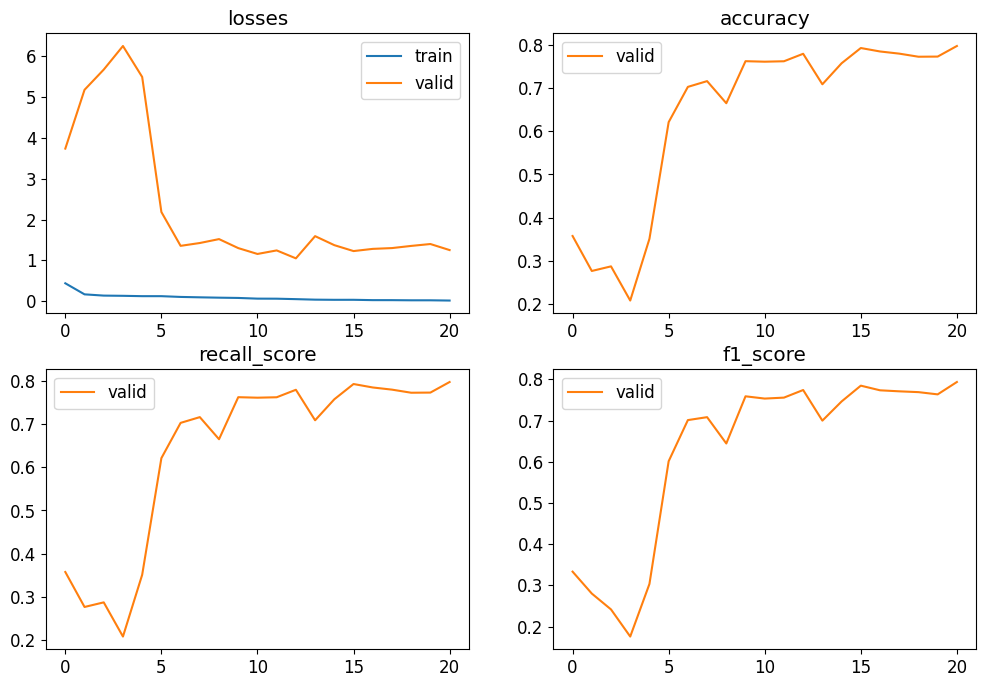

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.2508
Accuracy: 0.7975
Recall: 0.7975
F1-Score: 0.7936


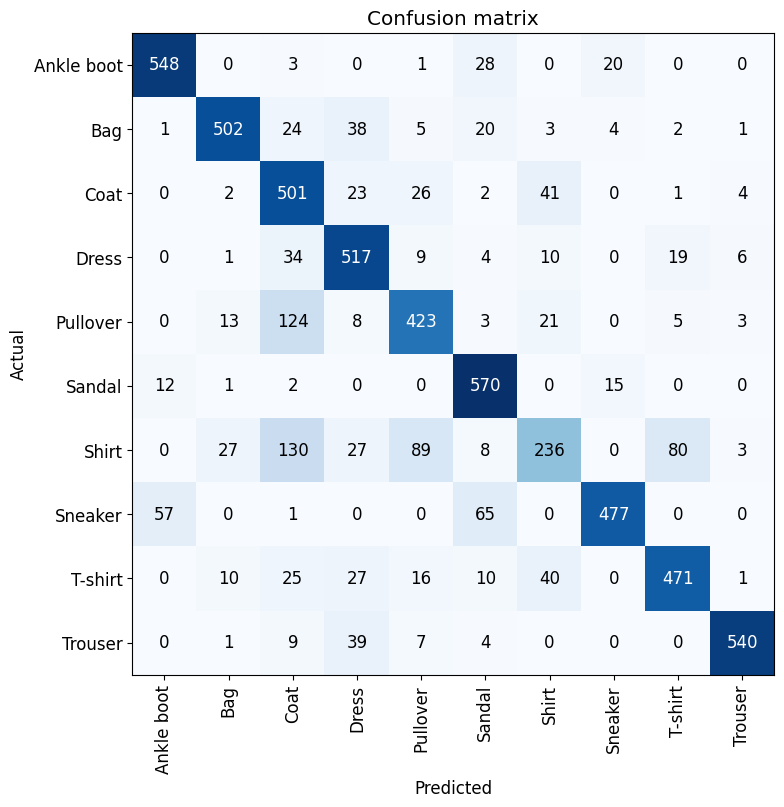

In [ ]:
#Creamos la interpretación de nuestro learner
interp = ClassificationInterpretation.from_learner(learn)

#Visualizamos la matriz de confusión
interp.plot_confusion_matrix(figsize=(8,8), dpi=100)

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_5cluster01_v3.pkl')

Example 2

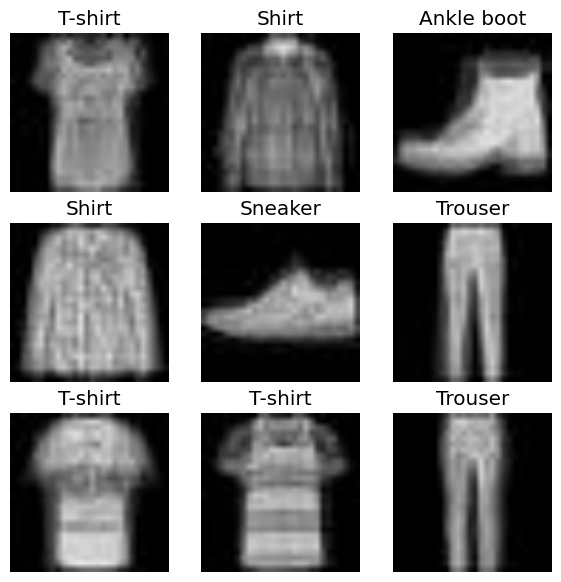

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 15: early stopping

Tiempo de entrenamiento: 1063.70 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.1259
Accuracy: 0.8015
Recall: 0.8015
F1-Score: 0.8005


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_5cluster02_v3.pkl')

Example 3

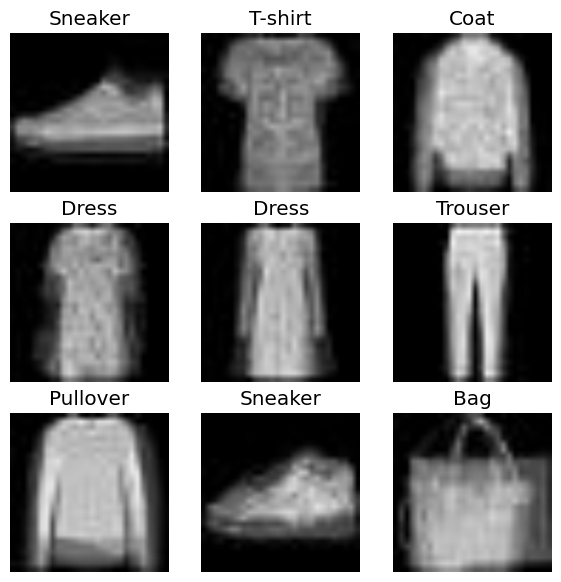

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 17: early stopping

Tiempo de entrenamiento: 1155.29 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.2168
Accuracy: 0.8053
Recall: 0.8053
F1-Score: 0.8022


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_5cluster03_v3.pkl')

Example 4

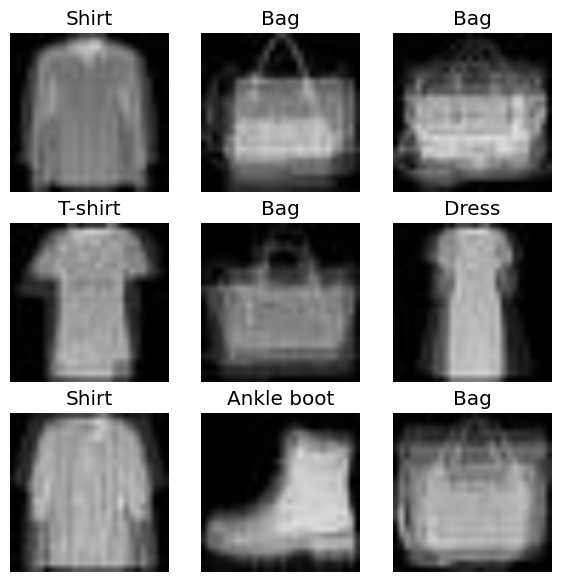

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 14: early stopping

Tiempo de entrenamiento: 1030.65 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.2513
Accuracy: 0.7997
Recall: 0.7997
F1-Score: 0.7986


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_5cluster04_v3.pkl')

Example 5

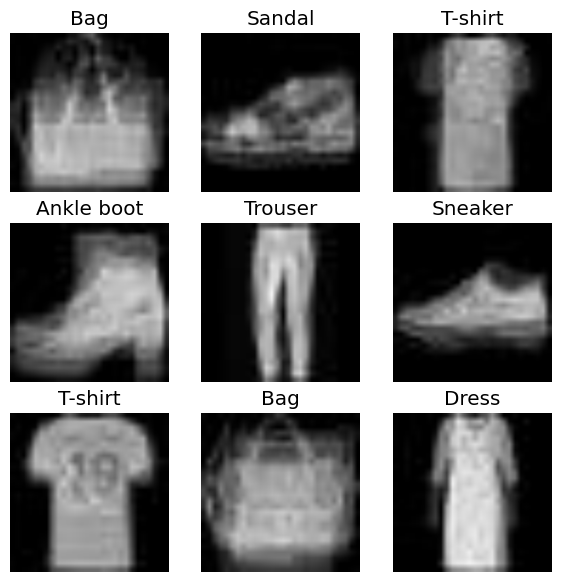

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.8),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 10: early stopping

Tiempo de entrenamiento: 846.36 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.4412
Accuracy: 0.7710
Recall: 0.7710
F1-Score: 0.7592


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_5cluster05_v3.pkl')

# Apartado 4

## Base - Lenet

Example 1

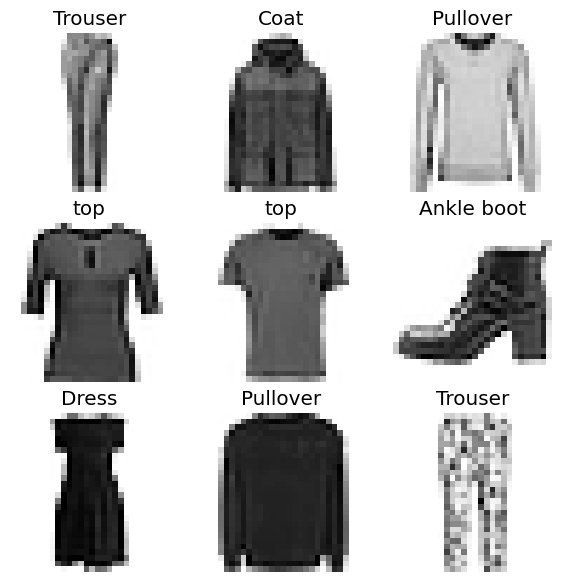

In [12]:
# Crear los DataLoaders
blocks = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction2(p, train_fraction=0.5),
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.2, seed=42)
)

# Crear los DataLoaders
dls = blocks.dataloaders(dataset_root, bs=64)

# Mostrar una muestra de las imágenes para verificar la correcta organización
dls.show_batch(max_n=9, figsize=(7,7))


Número total de imágenes en entrenamiento: 26353
Número total de imágenes en validación: 6588

Clases: ['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'Trouser', 'top']


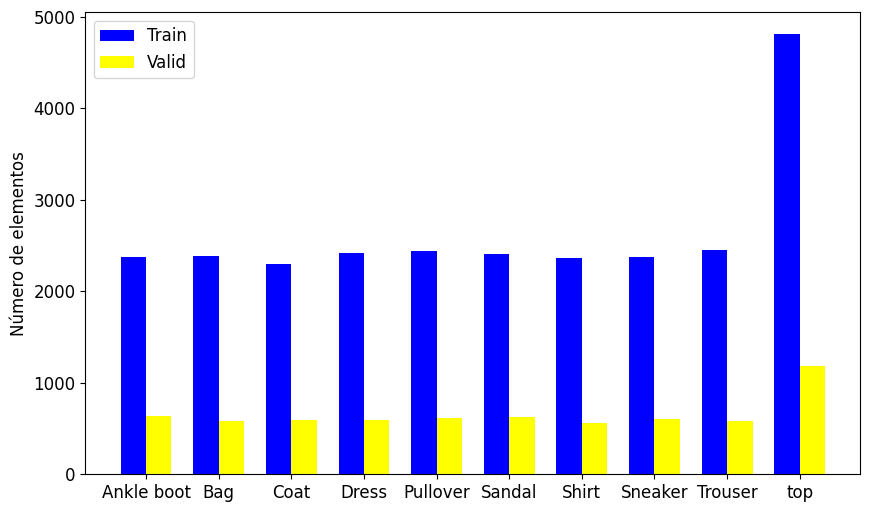

In [13]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])


In [ ]:
start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")


Tiempo de entrenamiento: 1053.85 segundos


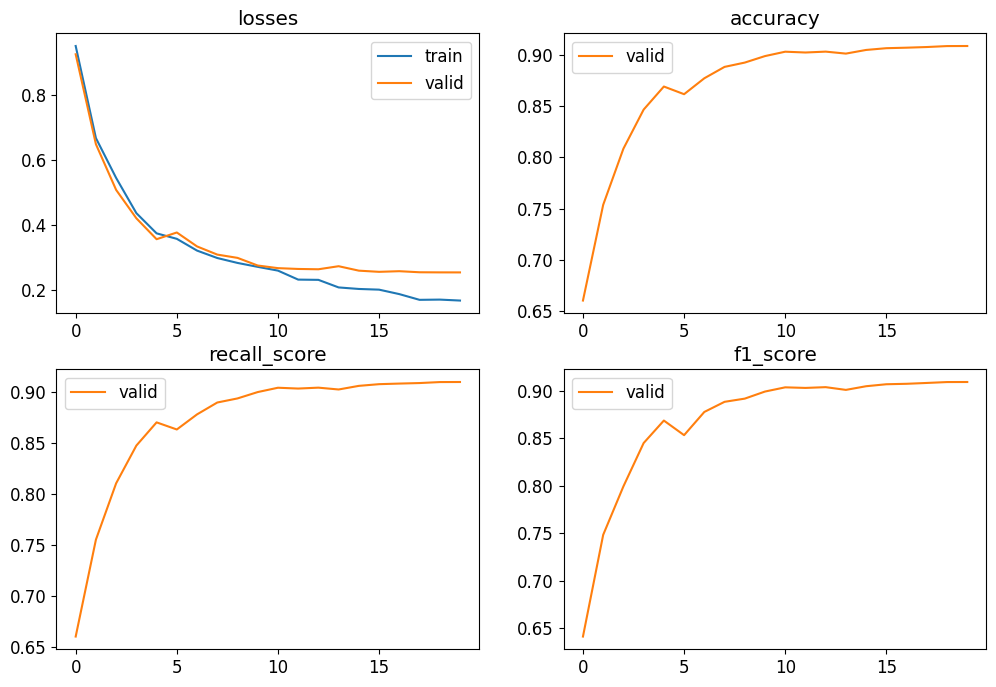

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.2544
Accuracy: 0.9090
Recall: 0.9093
F1-Score: 0.9090


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_2cluster01_v3.pkl')

## Leneet 001

In [ ]:
dst = base_path / "distilled_001"

Example 1

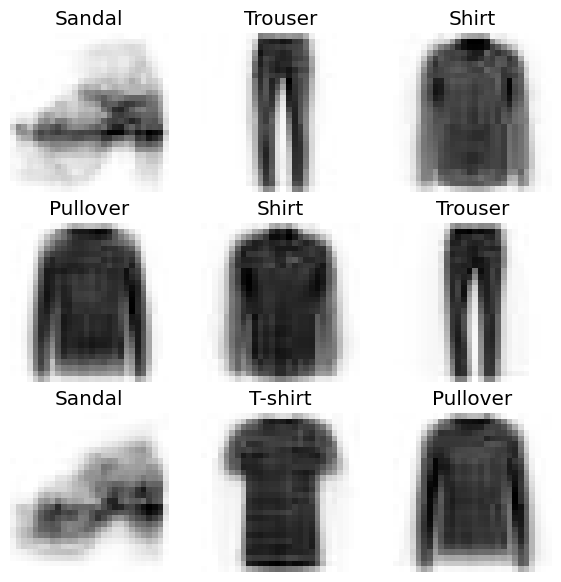

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

Número total de imágenes en entrenamiento: 516
Número total de imágenes en validación: 600

Clases: ['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'T-shirt', 'Trouser']


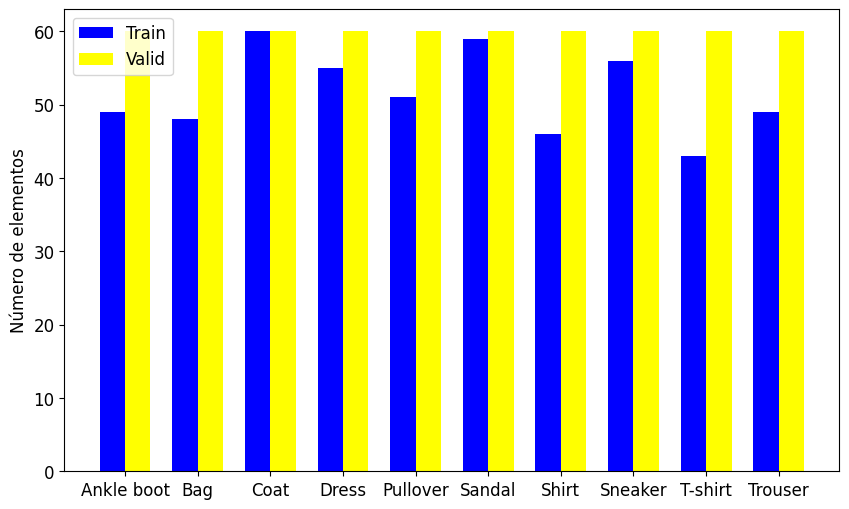

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 6: early stopping

Tiempo de entrenamiento: 27.08 segundos


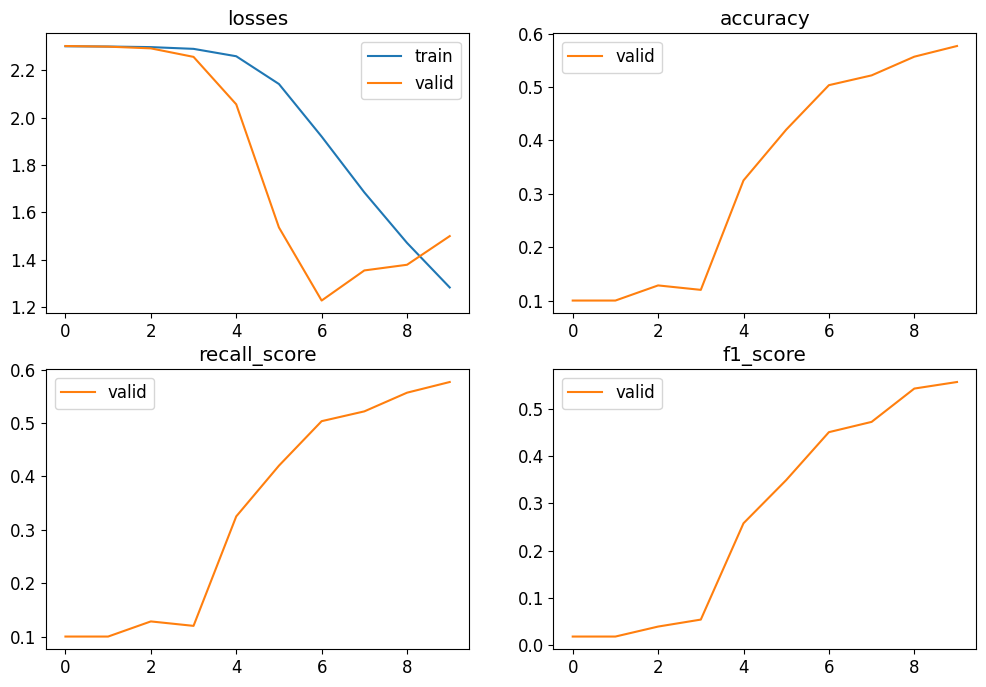

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.4993
Accuracy: 0.5767
Recall: 0.5767
F1-Score: 0.5571


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_2cluster01_v3.pkl')

Example 2

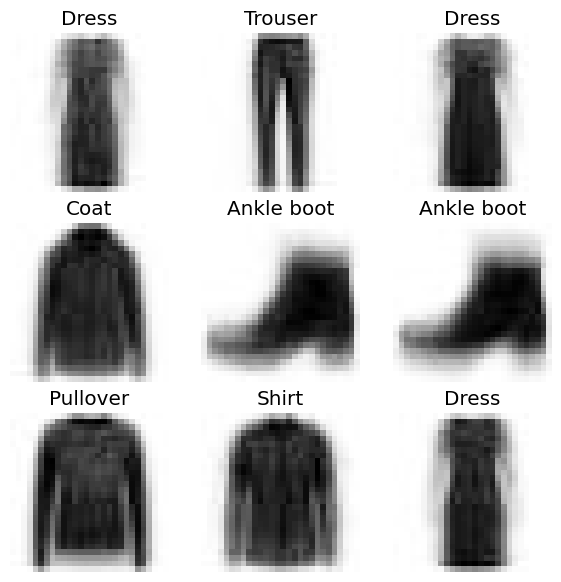

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 7: early stopping

Tiempo de entrenamiento: 24.33 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.8687
Accuracy: 0.5400
Recall: 0.5400
F1-Score: 0.5117


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_2cluster02_v3.pkl')

Example 3

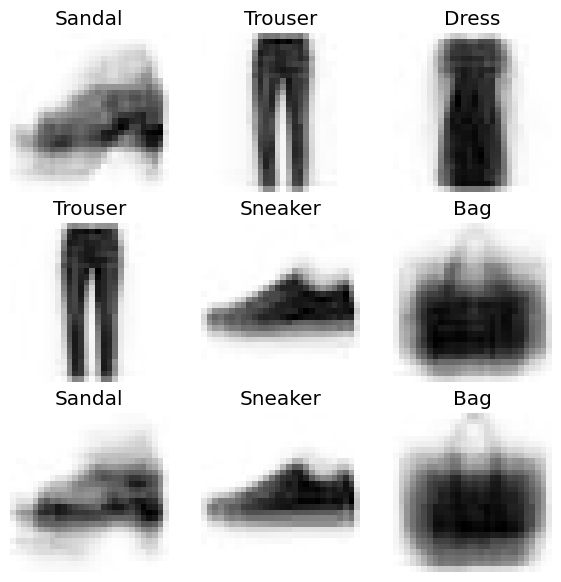

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 6: early stopping

Tiempo de entrenamiento: 18.20 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.3576
Accuracy: 0.5800
Recall: 0.5800
F1-Score: 0.5543


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_2cluster03_v3.pkl')

Example 4

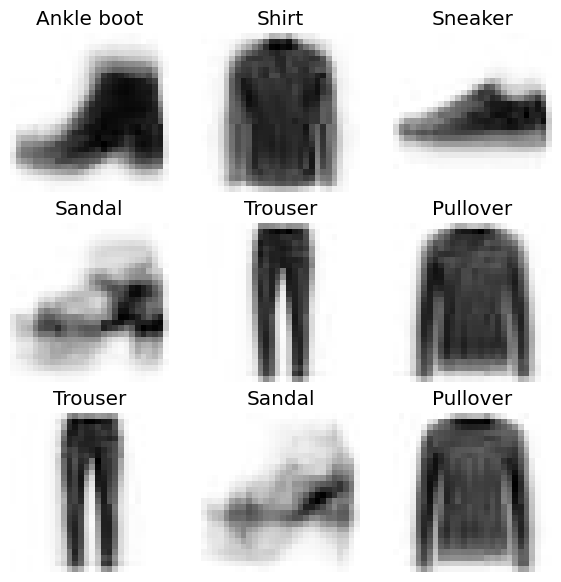

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 8: early stopping

Tiempo de entrenamiento: 23.01 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.6430
Accuracy: 0.5533
Recall: 0.5533
F1-Score: 0.5333


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_2cluster04_v3.pkl')

eXample 5

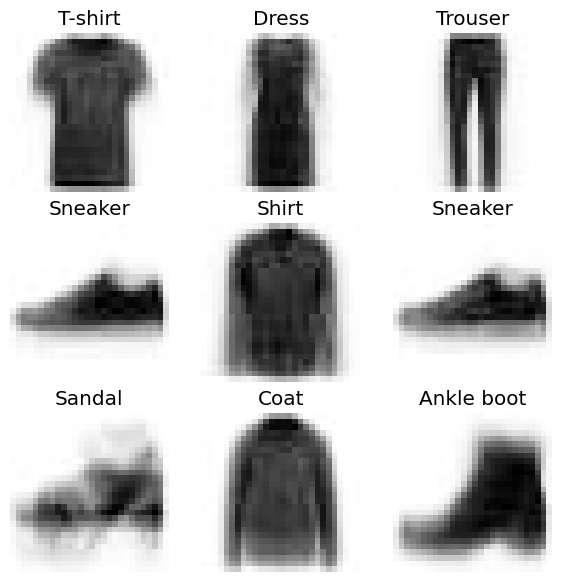

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 7: early stopping

Tiempo de entrenamiento: 21.51 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.3921
Accuracy: 0.5267
Recall: 0.5267
F1-Score: 0.5036


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_2cluster05_v3.pkl')

## Lenet 005

In [ ]:
dst = base_path / "distilled_005"

Exampel 1

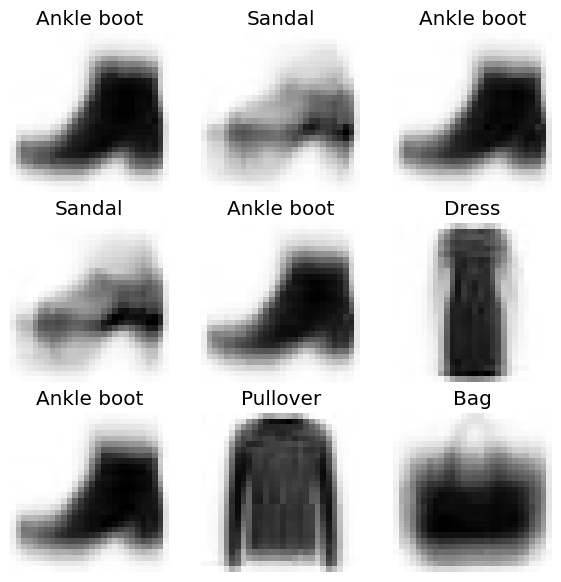

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

Número total de imágenes en entrenamiento: 107
Número total de imágenes en validación: 300

Clases: ['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'T-shirt', 'Trouser']


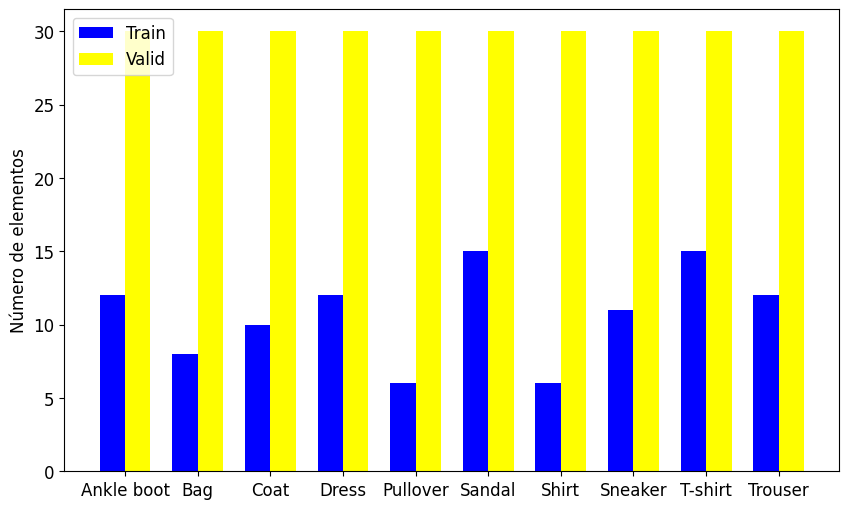

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")


Tiempo de entrenamiento: 20.57 segundos


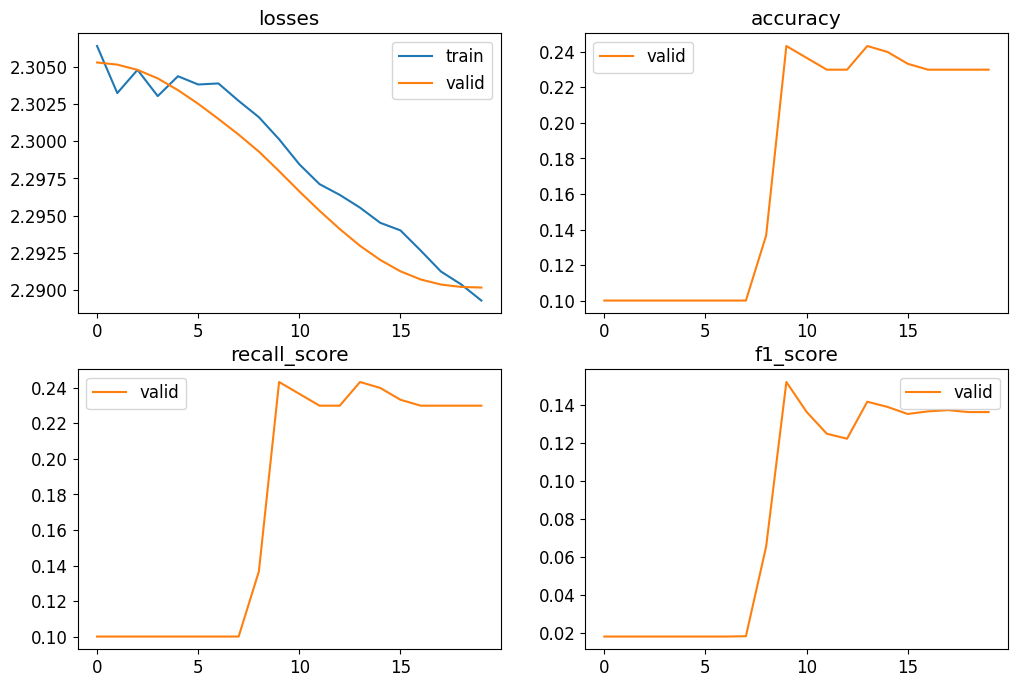

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 2.2901
Accuracy: 0.2300
Recall: 0.2300
F1-Score: 0.1361


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_2cluster01_v3.pkl')

Example 2

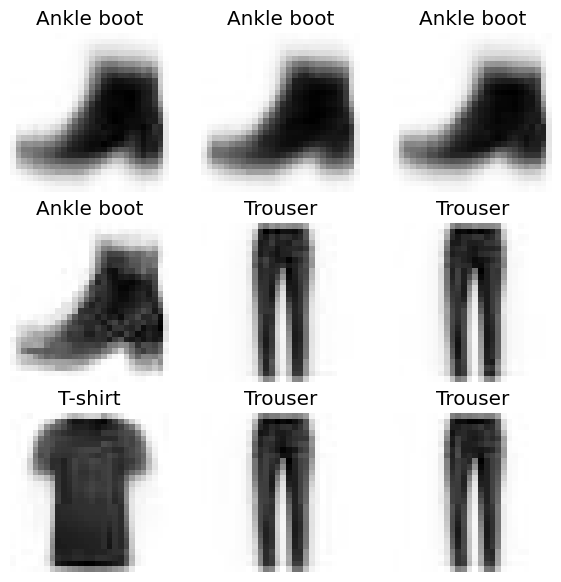

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")


Tiempo de entrenamiento: 19.77 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 2.2811
Accuracy: 0.1567
Recall: 0.1567
F1-Score: 0.0573


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_2cluster02_v3.pkl')

Example 3

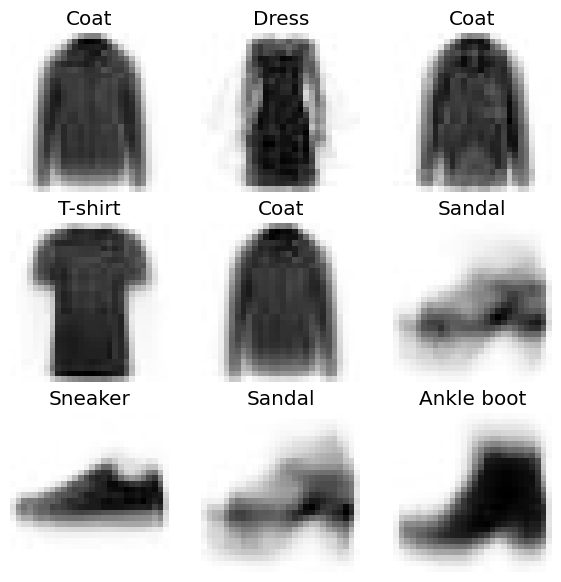

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")


Tiempo de entrenamiento: 21.30 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 2.2814
Accuracy: 0.2100
Recall: 0.2100
F1-Score: 0.0950


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_2cluster03_v3.pkl')

Example 4

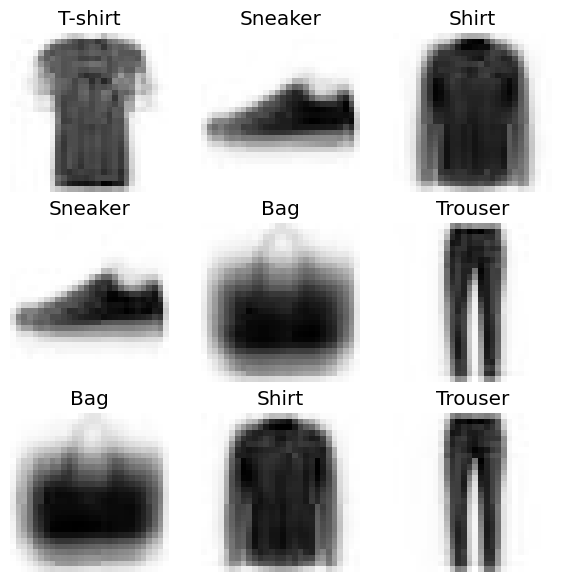

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")


Tiempo de entrenamiento: 15.70 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 2.2871
Accuracy: 0.3033
Recall: 0.3033
F1-Score: 0.2120


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_2cluster04_v3.pkl')

Example 5

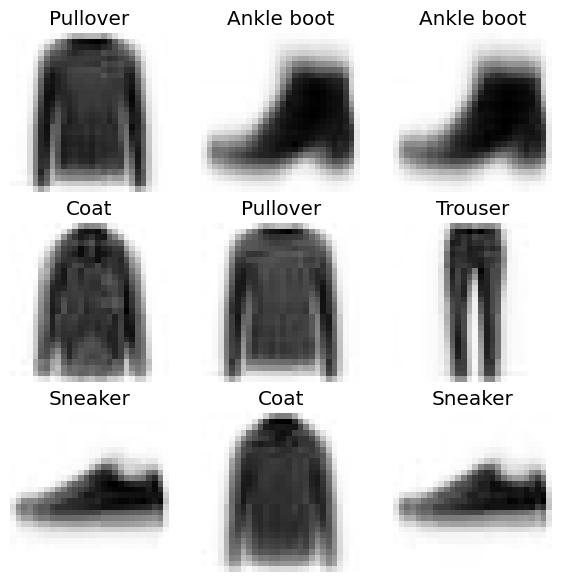

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")


Tiempo de entrenamiento: 12.72 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 2.2757
Accuracy: 0.1733
Recall: 0.1733
F1-Score: 0.0761


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_2cluster05_v3.pkl')

## Lenet 0001

In [ ]:
dst = base_path / "distilled_0001"

Exaple 1

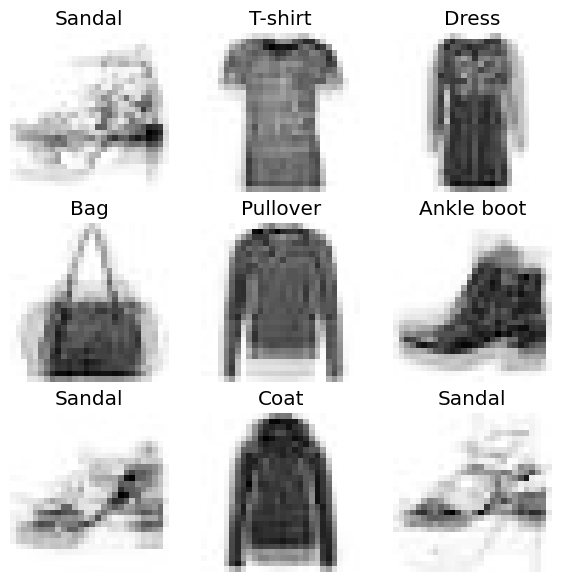

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

Número total de imágenes en entrenamiento: 5384
Número total de imágenes en validación: 6000

Clases: ['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'T-shirt', 'Trouser']


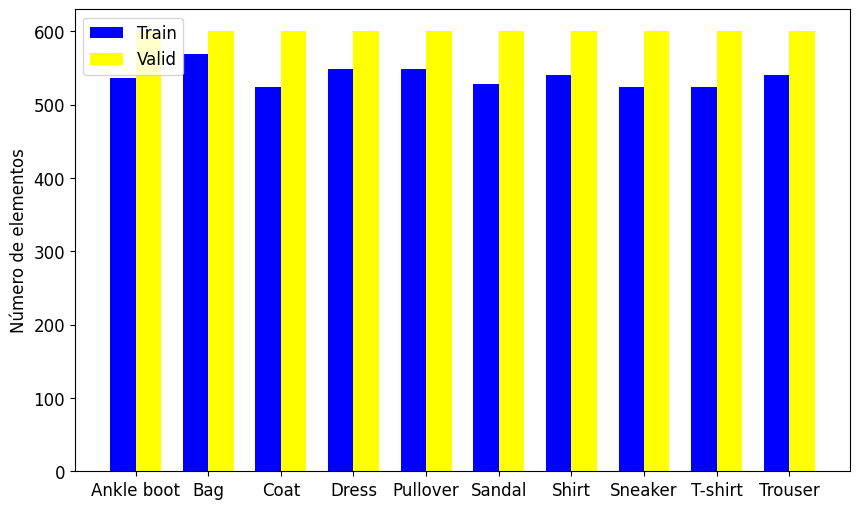

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 1: early stopping

Tiempo de entrenamiento: 48.05 segundos


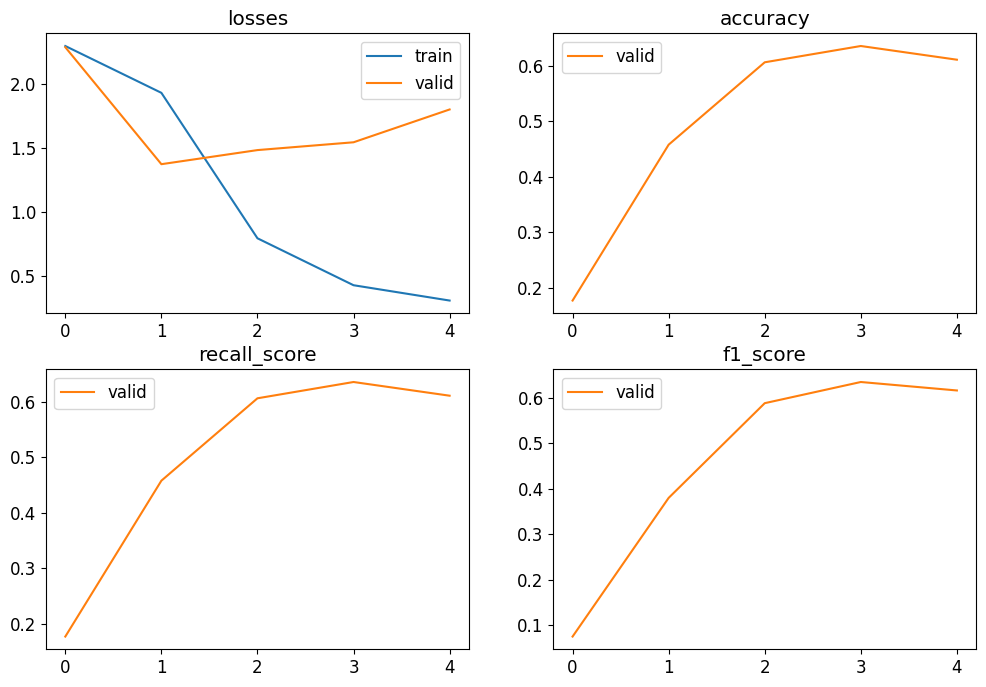

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.8011
Accuracy: 0.6105
Recall: 0.6105
F1-Score: 0.6155


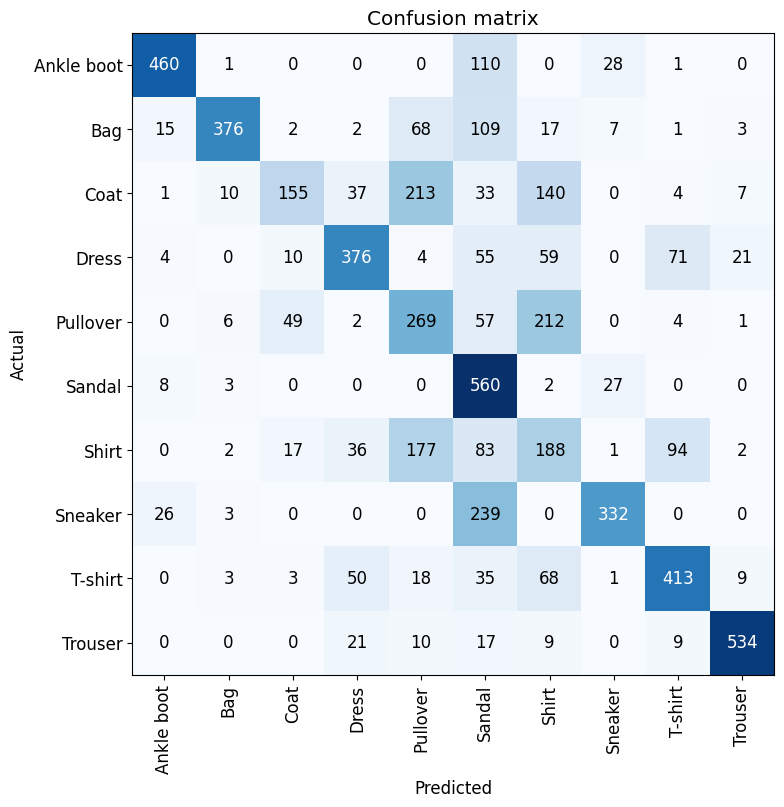

In [ ]:
#Creamos la interpretación de nuestro learner
interp = ClassificationInterpretation.from_learner(learn)

#Visualizamos la matriz de confusión
interp.plot_confusion_matrix(figsize=(8,8), dpi=100)

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_2cluster01_v3.pkl')

Example 2

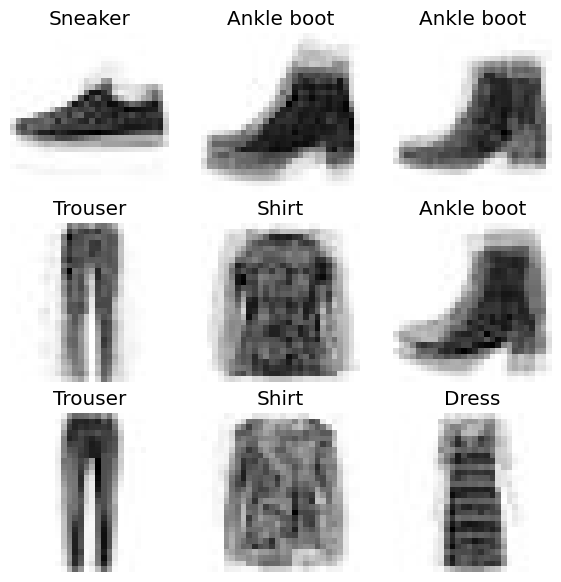

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 2: early stopping

Tiempo de entrenamiento: 60.52 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.4238
Accuracy: 0.6672
Recall: 0.6672
F1-Score: 0.6514


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_2cluster02_v3.pkl')

example 3

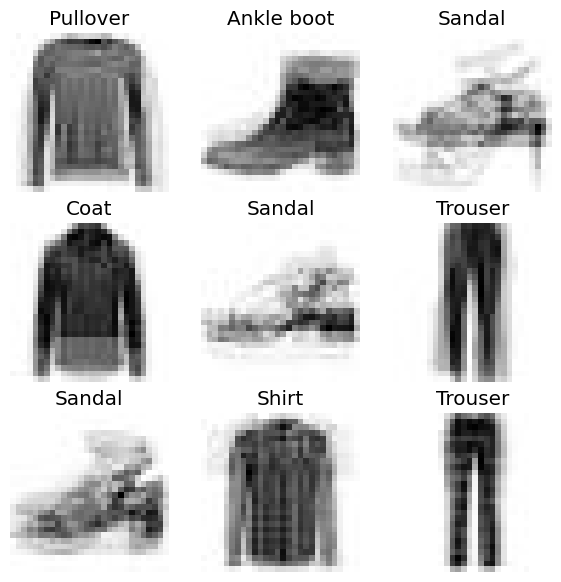

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 1: early stopping

Tiempo de entrenamiento: 44.20 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.4340
Accuracy: 0.6798
Recall: 0.6798
F1-Score: 0.6760


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_2cluster03_v3.pkl')

Example 4

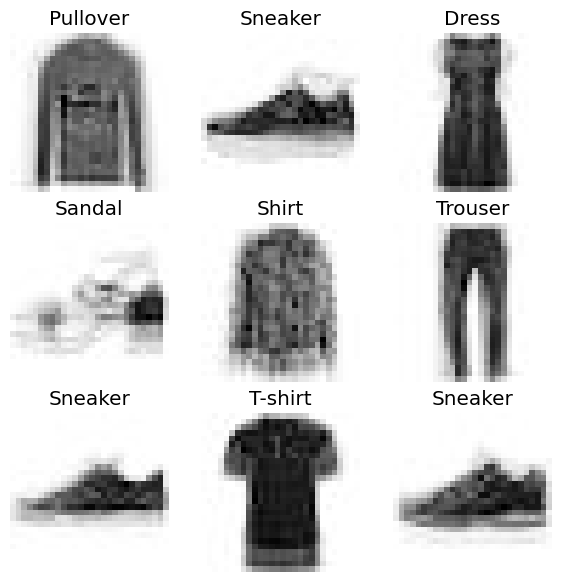

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 2: early stopping

Tiempo de entrenamiento: 52.66 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.2699
Accuracy: 0.6880
Recall: 0.6880
F1-Score: 0.6854


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_2cluster04_v3.pkl')

Example 5

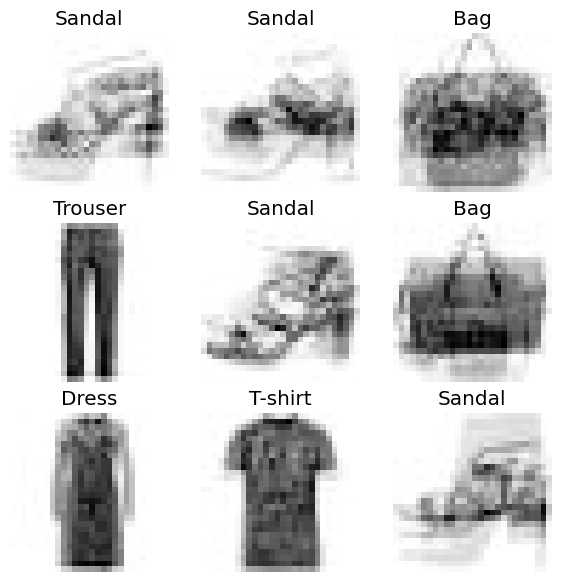

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 2: early stopping

Tiempo de entrenamiento: 54.34 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.4401
Accuracy: 0.6815
Recall: 0.6815
F1-Score: 0.6761


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_2cluster05_v3.pkl')

## Base - Resnet

Example 1

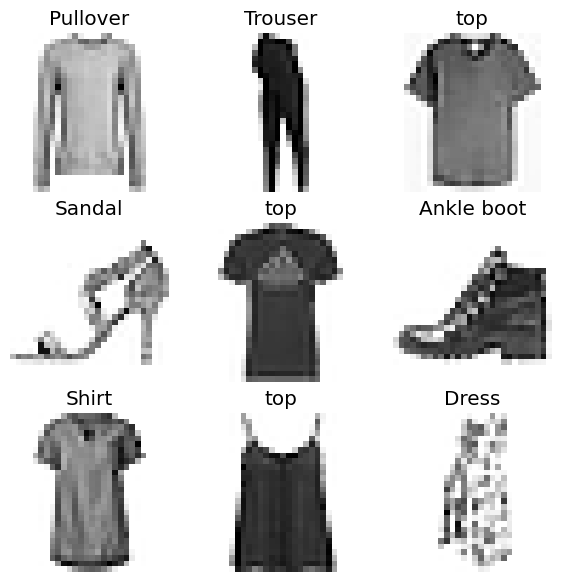

In [14]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction2(p, train_fraction=0.5),
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = blocks.dataloaders(dataset_root, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [15]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

Número total de imágenes en entrenamiento: 26240
Número total de imágenes en validación: 6559

Clases: ['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'Trouser', 'top']


In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 7: early stopping

Tiempo de entrenamiento: 2648.35 segundos


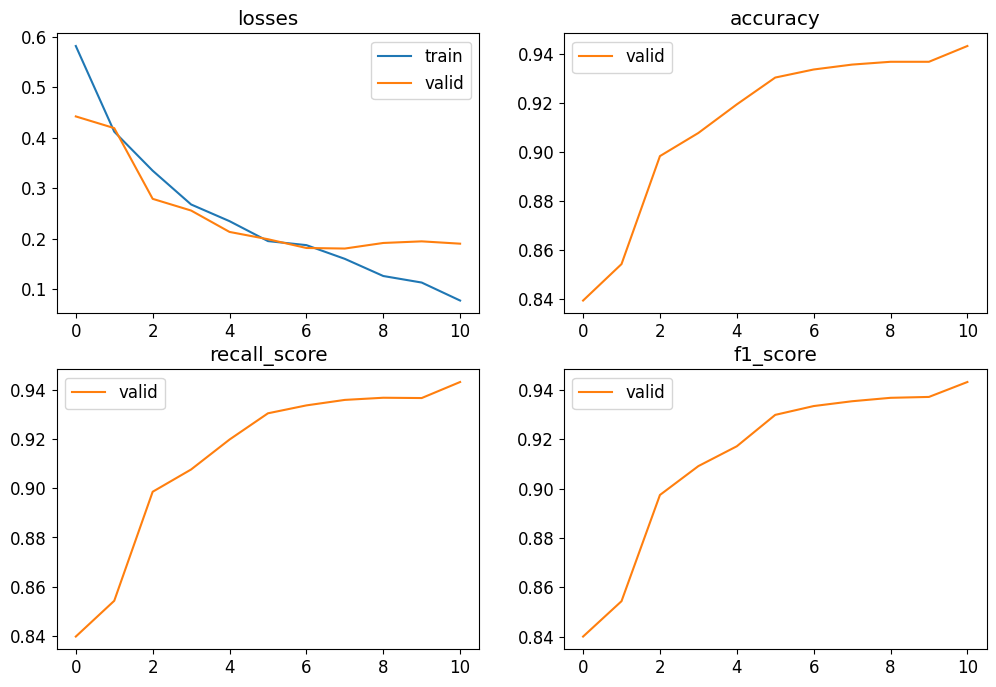

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.1903
Accuracy: 0.9431
Recall: 0.9432
F1-Score: 0.9432


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_2cluster01_v3.pkl')

## Resnet 001

In [ ]:
dst = base_path / "distilled_001"

Example 1

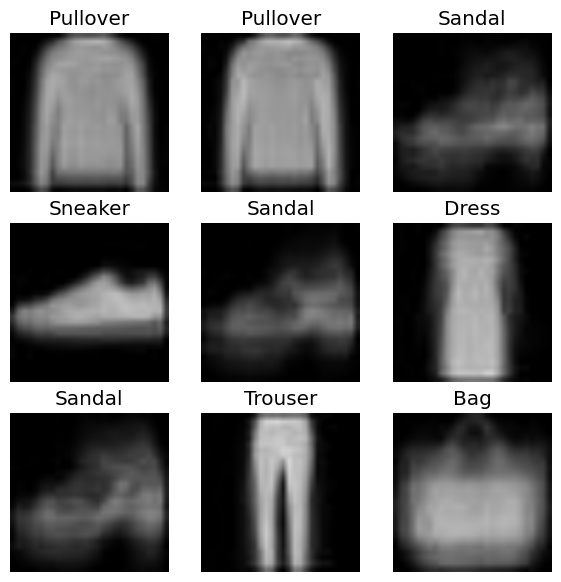

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

Número total de imágenes en entrenamiento: 483
Número total de imágenes en validación: 600

Clases: ['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'T-shirt', 'Trouser']


In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 0: early stopping

Tiempo de entrenamiento: 15.18 segundos


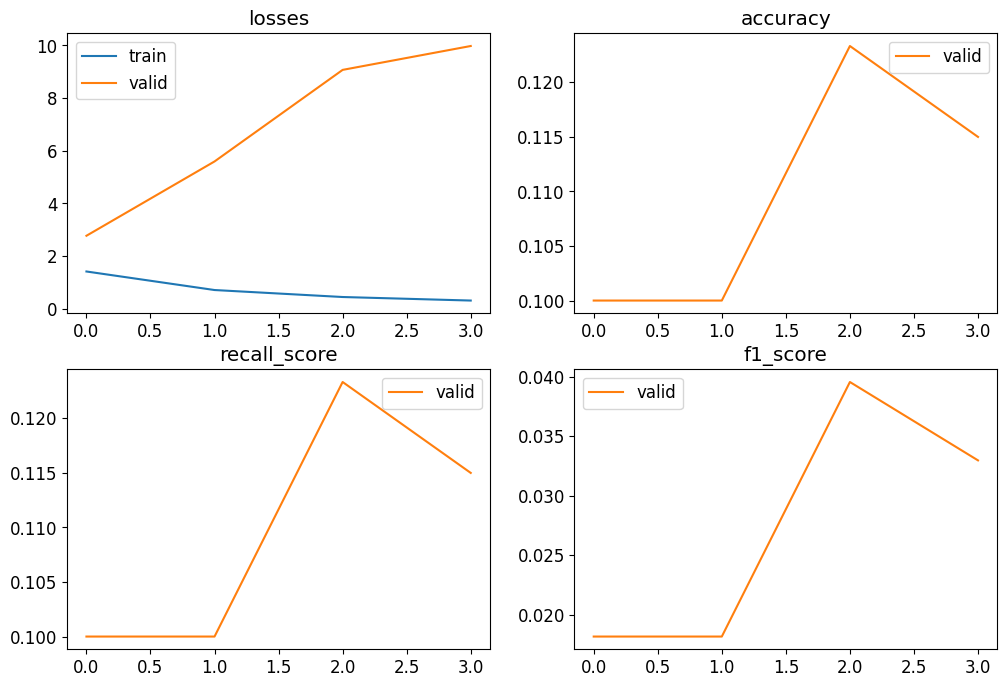

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 9.9791
Accuracy: 0.1150
Recall: 0.1150
F1-Score: 0.0330


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_2cluster01_v3.pkl')

Example 2

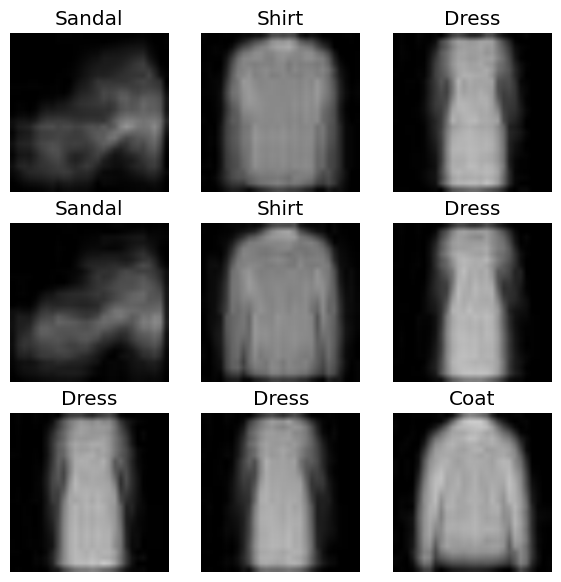

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 0: early stopping

Tiempo de entrenamiento: 19.36 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 7.3926
Accuracy: 0.2067
Recall: 0.2067
F1-Score: 0.1520


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_2cluster02_v3.pkl')

Example 3

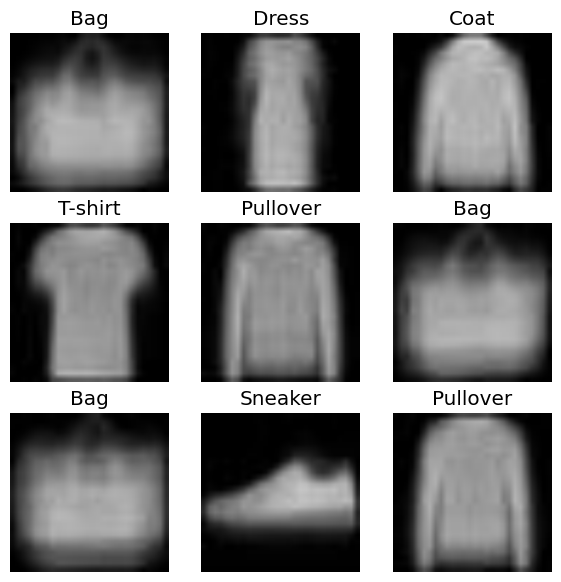

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 0: early stopping

Tiempo de entrenamiento: 21.75 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 11.4685
Accuracy: 0.1050
Recall: 0.1050
F1-Score: 0.0256


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_2cluster03_v3.pkl')

## Resnet 005

In [ ]:
dst = base_path / "distilled_005"

Example 1

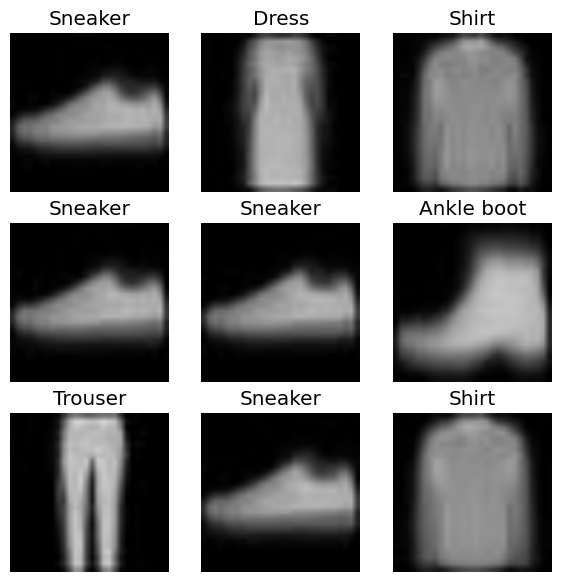

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

Número total de imágenes en entrenamiento: 99
Número total de imágenes en validación: 300

Clases: ['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'T-shirt', 'Trouser']


In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 0: early stopping

Tiempo de entrenamiento: 8.68 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 2.5788
Accuracy: 0.1033
Recall: 0.1033
F1-Score: 0.0245


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_2cluster01_v3.pkl')

Example 2

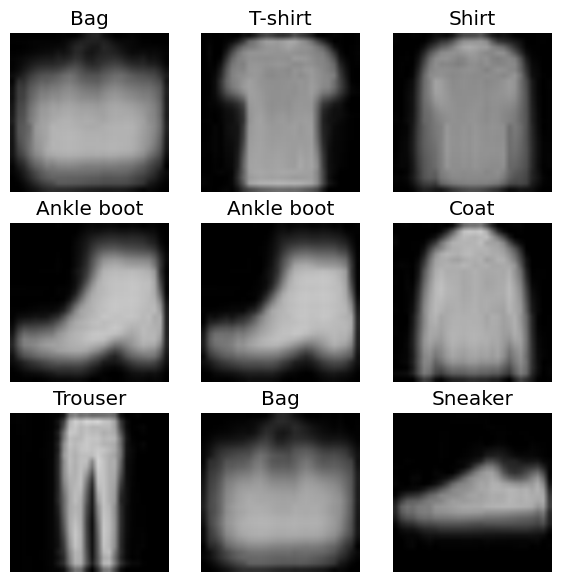

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 0: early stopping

Tiempo de entrenamiento: 7.82 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 2.4718
Accuracy: 0.1000
Recall: 0.1000
F1-Score: 0.0183


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_2cluster02_v3.pkl')

Example 3

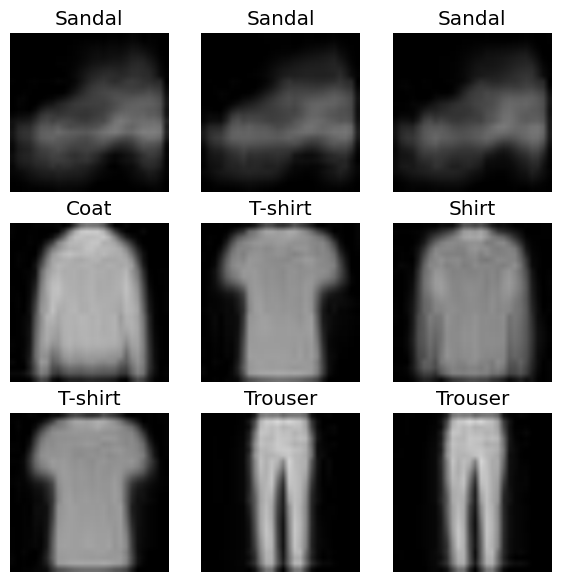

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 1: early stopping

Tiempo de entrenamiento: 11.56 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 3.0820
Accuracy: 0.1000
Recall: 0.1000
F1-Score: 0.0185


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_2cluster03_v3.pkl')

## Resnet 0001

In [ ]:
dst = base_path / "distilled_0001"

Example 1

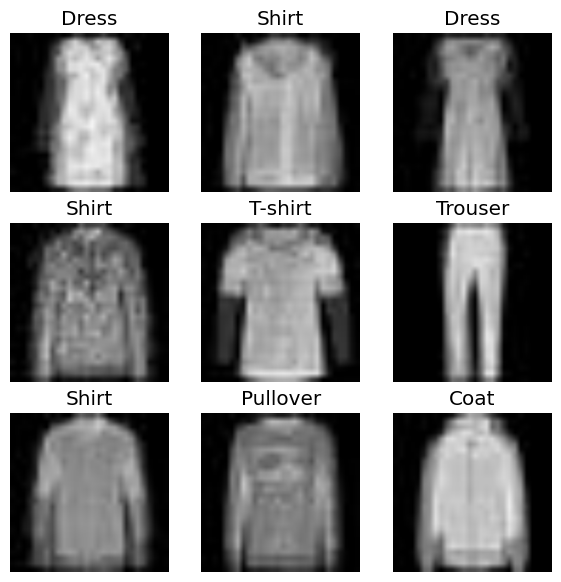

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

Número total de imágenes en entrenamiento: 5390
Número total de imágenes en validación: 6000

Clases: ['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'T-shirt', 'Trouser']


In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 19: early stopping

Tiempo de entrenamiento: 947.43 segundos


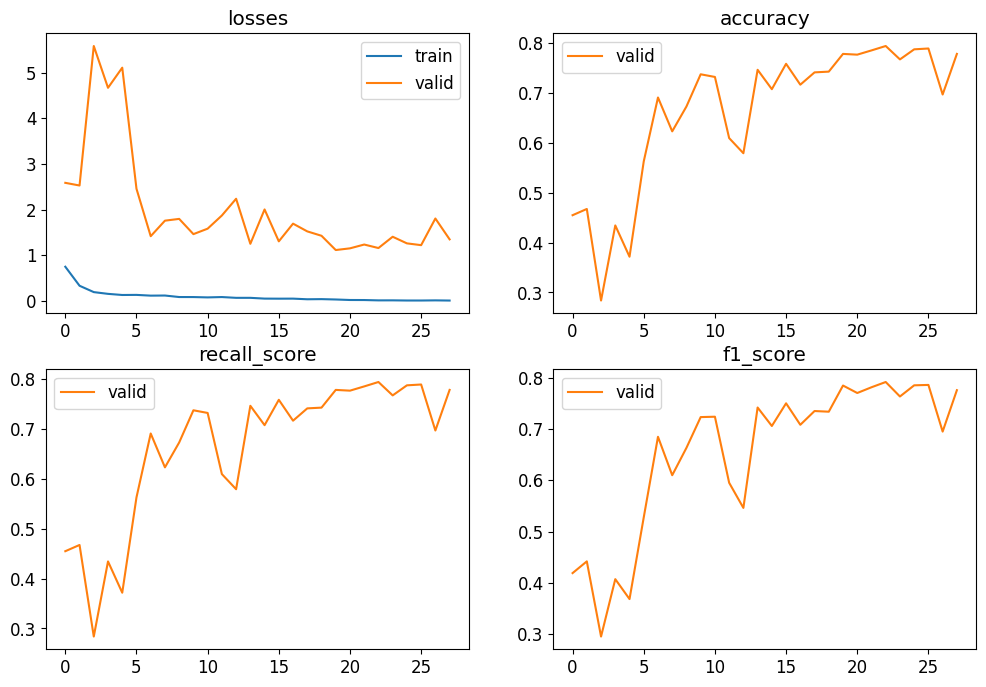

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.3465
Accuracy: 0.7780
Recall: 0.7780
F1-Score: 0.7755


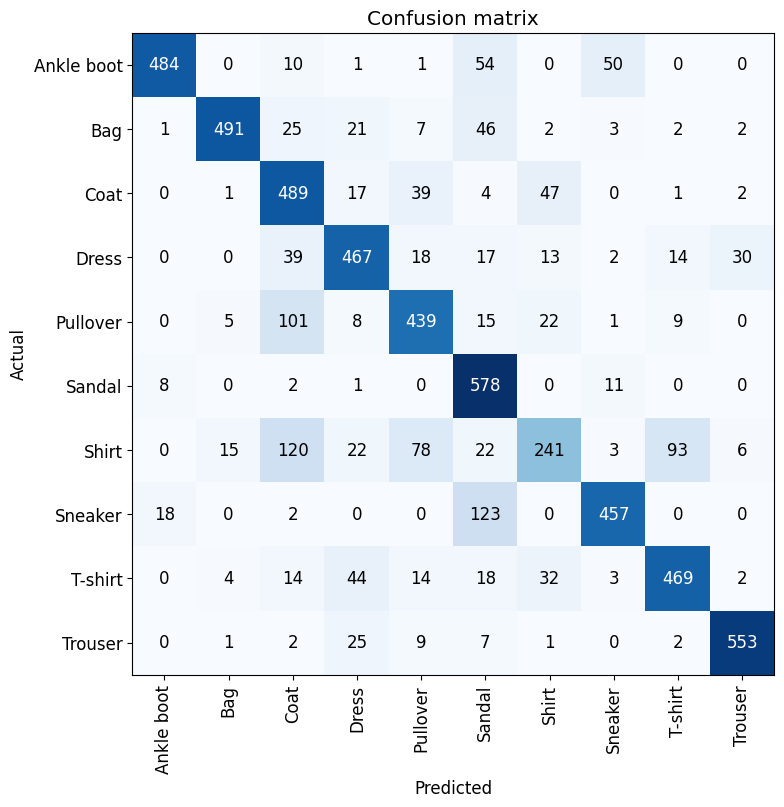

In [ ]:
#Creamos la interpretación de nuestro learner
interp = ClassificationInterpretation.from_learner(learn)

#Visualizamos la matriz de confusión
interp.plot_confusion_matrix(figsize=(8,8), dpi=100)

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_2cluster01_v3.pkl')

Example 2

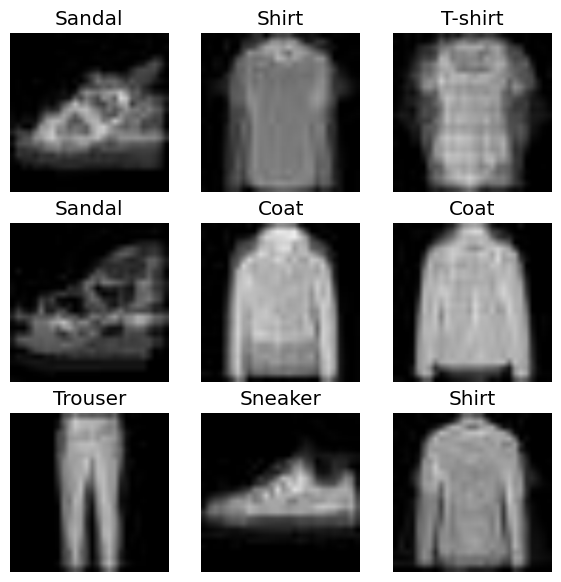

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 13: early stopping

Tiempo de entrenamiento: 721.29 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.1470
Accuracy: 0.7912
Recall: 0.7912
F1-Score: 0.7872


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_2cluster02_v3.pkl')

Example 3

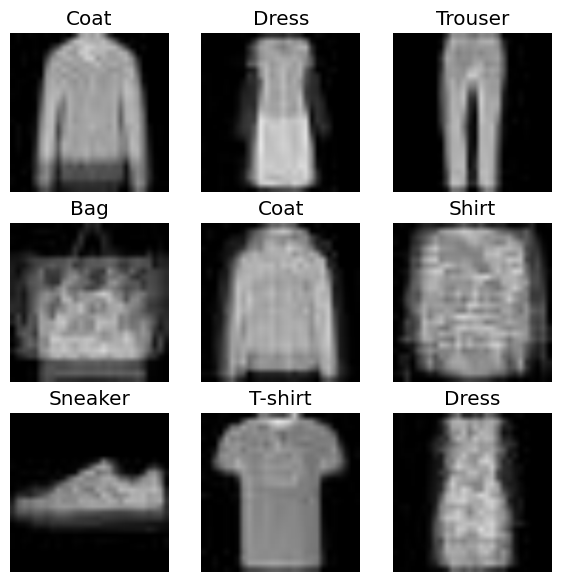

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 13: early stopping

Tiempo de entrenamiento: 723.04 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.3703
Accuracy: 0.7282
Recall: 0.7282
F1-Score: 0.7289


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_2cluster03_v3.pkl')

Example 4

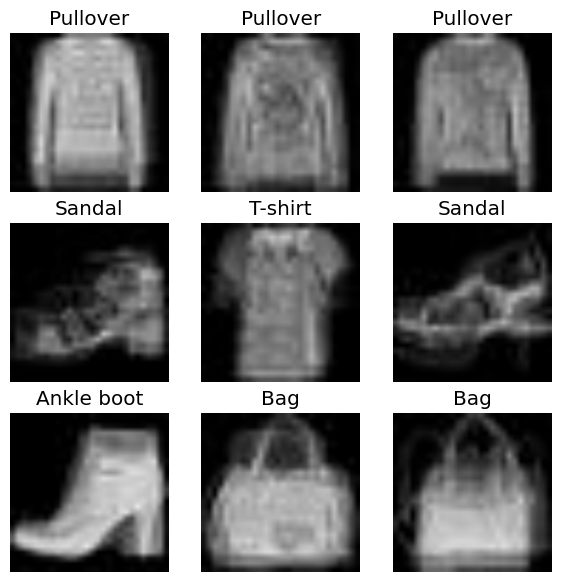

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 7: early stopping

Tiempo de entrenamiento: 525.72 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.1628
Accuracy: 0.7647
Recall: 0.7647
F1-Score: 0.7594


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_2cluster04_v3.pkl')

Example 05

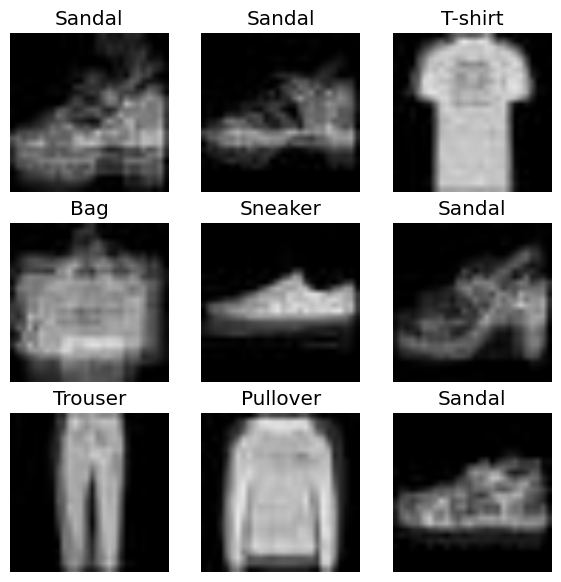

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_items_fraction(p, train_fraction=0.5),
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 23: early stopping

Tiempo de entrenamiento: 1038.90 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.1746
Accuracy: 0.7998
Recall: 0.7998
F1-Score: 0.7973


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_2cluster05_v3.pkl')

# TEST

In [26]:
test_path = Path('/content/dataset/original/fashion_mnist/test')

## Lenet original

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_original_v3.pkl')

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(test_path, bs=64)

In [ ]:
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.2917487323284149
Accuracy: 0.8996394276618958
Recall (macro): 0.8997027154412004
F1 Score (macro): 0.8994298715505769


## Resnet18 original

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_original_v3.pkl')

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=Resize(224),
    splitter=RandomSplitter(valid_pct=0.0)
)

test_dls = test_block.dataloaders(test_path)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')


Loss: 0.2595
Accuracy: 0.9329
Recall: 0.9329
F1-Score: 0.9328


## Distilled 001 - L enet

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(test_path, bs=64)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 5.047307968139648
Accuracy: 0.4175681173801422
Recall (macro): 0.4175305139214586
F1 Score (macro): 0.407420747473751


## Distilled Lenet 005

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.9677250385284424
Accuracy: 0.4320913553237915
Recall (macro): 0.4322299600128897
F1 Score (macro): 0.4295120662103247


## Distilled 00001 - Lneet

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 4.295670986175537
Accuracy: 0.5343549847602844
Recall (macro): 0.5342889220195399
F1 Score (macro): 0.5335911241266955


## Resnet 001

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=Resize(224),
    splitter=RandomSplitter(valid_pct=0.0)
)

test_dls = test_block.dataloaders(test_path)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_v3.pkl')

In [ ]:
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 26.980859756469727
Accuracy: 0.10126201808452606
Recall (macro): 0.10129859479200085
F1 Score (macro): 0.028655132007671315


## Resnet 005

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_v3.pkl')

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 6.23865270614624
Accuracy: 0.10086137801408768
Recall (macro): 0.1007007007007007
F1 Score (macro): 0.01963200065050962


## Resnet 0001

Example 1

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_v3.pkl')

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 4.561984062194824
Accuracy: 0.6135817170143127
Recall (macro): 0.6136432528316684
F1 Score (macro): 0.609226773287621


## Base & 5 cluster - Lenet

In [27]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(test_path)

In [28]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_5cluster01_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [29]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.30556032061576843
Accuracy: 0.8924278616905212
Recall (macro): 0.8923527258767925
F1 Score (macro): 0.8917414266672445


## Distilled 001 & 5 cluster - Lenet

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(test_path, bs=64)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_5cluster01_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 3.9641125202178955
Accuracy: 0.39983972907066345
Recall (macro): 0.3998334400337847
F1 Score (macro): 0.39278507591506584


 Distilled 001 & 5 cluster - Lenet Ex2


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_5cluster02_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 3.320676326751709
Accuracy: 0.41326120495796204
Recall (macro): 0.4135294284254164
F1 Score (macro): 0.4201570240319505


Distilled 001 & 5 cluster - Lenet Ex3


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_5cluster03_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 3.452927350997925
Accuracy: 0.46364182233810425
Recall (macro): 0.46374250051805765
F1 Score (macro): 0.4562947170150002


Distilled 001 & 5 cluster - Lenet Ex4


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_5cluster04_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 3.029608964920044
Accuracy: 0.4379006326198578
Recall (macro): 0.43806332349055754
F1 Score (macro): 0.4191167602258637


Distilled 001 & 5 cluster - Lenet Ex5


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_5cluster05_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 5.7756242752075195
Accuracy: 0.3621794879436493
Recall (macro): 0.36210883646038294
F1 Score (macro): 0.3504160522600087


## Distilled 005 & 5 cluster - Lenet


In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(test_path, bs=64)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_5cluster01_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 1.5252395868301392
Accuracy: 0.3873197138309479
Recall (macro): 0.3872203106442401
F1 Score (macro): 0.339786640689557


Distilled 005 & 5 cluster - Lenet Ex2


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_5cluster02_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 1.7062911987304688
Accuracy: 0.3716947138309479
Recall (macro): 0.3717099072934399
F1 Score (macro): 0.32318024495134


Distilled 005 & 5 cluster - Lenet Ex3

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_5cluster03_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 1.518403172492981
Accuracy: 0.4765625
Recall (macro): 0.4764368023958151
F1 Score (macro): 0.45810285524960753


Distilled 005 & 5 cluster - Lenet Ex4


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_5cluster04_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 1.7523019313812256
Accuracy: 0.4442107379436493
Recall (macro): 0.44420189466933546
F1 Score (macro): 0.4267688882154254


Distilled 005 & 5 cluster - Lenet Ex5


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_5cluster05_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.0246551036834717
Accuracy: 0.4086538553237915
Recall (macro): 0.40870692957636895
F1 Score (macro): 0.38582082830791437


## Distilled 0001 & 5 cluster - Lenet


In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(test_path, bs=64)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_5cluster01_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 5.3854146003723145
Accuracy: 0.5492788553237915
Recall (macro): 0.549312593077215
F1 Score (macro): 0.5486094482631625


Distilled 0001 & 5 cluster - Lenet Ex2


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_5cluster02_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 4.5822529792785645
Accuracy: 0.5444711446762085
Recall (macro): 0.5446538017595597
F1 Score (macro): 0.537090309075053


Distilled 0001 & 5 cluster - Lenet Ex3


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_5cluster03_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 5.044599533081055
Accuracy: 0.5240384340286255
Recall (macro): 0.5239670667372944
F1 Score (macro): 0.5361272191435537


Distilled 0001 & 5 cluster - Lenet Ex4


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_5cluster04_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 4.19263219833374
Accuracy: 0.5564903616905212
Recall (macro): 0.5564897986406833
F1 Score (macro): 0.5595112720849416


Distilled 0001 & 5 cluster - Lenet Ex5


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_5cluster05_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 5.2340569496154785
Accuracy: 0.5246394276618958
Recall (macro): 0.5246123403495673
F1 Score (macro): 0.5265090900984999


## Base & 5 cluster - Resnet

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=Resize(224),
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(test_path)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_5cluster01_v3.pkl')


/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.06425542384386063
Accuracy: 0.9824719429016113
Recall (macro): 0.9824709410753257
F1 Score (macro): 0.9823787736523627


## Distilled 001 & 5 cluster - Resnet




In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=Resize(224),
    splitter=RandomSplitter(valid_pct=0.0)
)

test_dls = test_block.dataloaders(test_path)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_5cluster01_v3.pkl')

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 10.303150177001953
Accuracy: 0.15915465354919434
Recall (macro): 0.15918910081469473
F1 Score (macro): 0.10118582278312283


 Distilled 001 & 5 cluster - Resnet Ex2


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_5cluster02_v3.pkl')


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 4.51517391204834
Accuracy: 0.1668669879436493
Recall (macro): 0.1669887604528461
F1 Score (macro): 0.14283965432569717


 Distilled 001 & 5 cluster - Resnet Ex3


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_5cluster03_v3.pkl')


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 5.036006450653076
Accuracy: 0.18709935247898102
Recall (macro): 0.18693980834783647
F1 Score (macro): 0.09585170659564239


## Distilled 005 & 5 cluster - Resnet


In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.0, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224),
    )

test_dls = dblock.dataloaders(test_path)


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_5cluster01_v3.pkl')


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.77801775932312
Accuracy: 0.16796875
Recall (macro): 0.1679555330881984
F1 Score (macro): 0.05989933288465166


Distilled 005 & 5 cluster - Resnet Ex2


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_5cluster02_v3.pkl')


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 3.120920181274414
Accuracy: 0.16025641560554504
Recall (macro): 0.1603850630046452
F1 Score (macro): 0.053669887603175134


Distilled 005 & 5 cluster - Resnet Ex3


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_5cluster03_v3.pkl')


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 3.9487147331237793
Accuracy: 0.10046073794364929
Recall (macro): 0.10029999999999999
F1 Score (macro): 0.018812545809476118


## Distilled 0001 & 5 cluster - Resnet


In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.0, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224),
    )

test_dls = dblock.dataloaders(test_path)


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_5cluster01_v3.pkl')


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 4.357991695404053
Accuracy: 0.6207932829856873
Recall (macro): 0.6210106240829859
F1 Score (macro): 0.6118249192592209


Distilled 0001 & 5 cluster - Resnet Ex2


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_5cluster02_v3.pkl')


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 3.919276237487793
Accuracy: 0.624098539352417
Recall (macro): 0.6241633469492591
F1 Score (macro): 0.6226637097886026


Distilled 0001 & 5 cluster - Resnet Ex3


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_5cluster03_v3.pkl')


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 4.353611469268799
Accuracy: 0.6227964758872986
Recall (macro): 0.6226944119125661
F1 Score (macro): 0.6292651504582911


Distilled 0001 & 5 cluster - Resnet Ex4


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_5cluster04_v3.pkl')


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 4.359776973724365
Accuracy: 0.6291065812110901
Recall (macro): 0.6291385047348883
F1 Score (macro): 0.6272878522230239


Distilled 0001 & 5 cluster - Resnet Ex5

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_5cluster05_v3.pkl')


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 4.502020835876465
Accuracy: 0.602463960647583
Recall (macro): 0.6025531924226903
F1 Score (macro): 0.592738091384927


## Base & 2 cluster - Lenet

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(test_path)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_2cluster01_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.20149150490760803
Accuracy: 0.9273838400840759
Recall (macro): 0.9273504528933243
F1 Score (macro): 0.9270938772547991


## Distilled 001 & 2 cluster - Lenet

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(test_path)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_2cluster01_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.980152130126953
Accuracy: 0.4420072138309479
Recall (macro): 0.44191108411784824
F1 Score (macro): 0.4250181306992924


Distilled 001 & 2 cluster - Lenet Ex 2

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_2cluster02_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.703176736831665
Accuracy: 0.41656652092933655
Recall (macro): 0.4166392566008662
F1 Score (macro): 0.38370581347632327


Distilled 001 & 2 cluster - Lenet Ex 3

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_2cluster03_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.422877550125122
Accuracy: 0.43940305709838867
Recall (macro): 0.4392840683611191
F1 Score (macro): 0.41998126229500576


Distilled 001 & 2 cluster - Lenet Ex 4

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_2cluster04_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.7650578022003174
Accuracy: 0.4173677861690521
Recall (macro): 0.41732036384700183
F1 Score (macro): 0.41640447447308626


Distilled 001 & 2 cluster - Lenet Ex 5

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_2cluster05_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.3911681175231934
Accuracy: 0.4248798191547394
Recall (macro): 0.4250946054321667
F1 Score (macro): 0.3947119261110641


## Distilled 005 & 2 cluster - Lenet

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(test_path)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_2cluster01_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.2951581478118896
Accuracy: 0.16676682233810425
Recall (macro): 0.1669232354587016
F1 Score (macro): 0.0747835840087249


Distilled 005 & 2 cluster - Lenet Ex 2

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_2cluster02_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.286536931991577
Accuracy: 0.13491585850715637
Recall (macro): 0.1347
F1 Score (macro): 0.04779271467028047


Distilled 005 & 2 cluster - Lenet Ex 3

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_2cluster03_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.284484386444092
Accuracy: 0.20602965354919434
Recall (macro): 0.2059522913083595
F1 Score (macro): 0.09433628713503661


Distilled 005 & 2 cluster - Lenet Ex 4

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_2cluster04_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.2895026206970215
Accuracy: 0.2423878163099289
Recall (macro): 0.24242889933936745
F1 Score (macro): 0.14688474823713052


Distilled 005 & 2 cluster - Lenet Ex 5

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_2cluster05_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.280017614364624
Accuracy: 0.16195914149284363
Recall (macro): 0.16186186186186186
F1 Score (macro): 0.06695111216123348


## Distilled 0001 & 2 cluster - Lenet


In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(test_path)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_2cluster01_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 3.718251943588257
Accuracy: 0.5216346383094788
Recall (macro): 0.5217179311137768
F1 Score (macro): 0.5228053505272251


Distilled 0001 & 2 cluster - Lenet Ex 2

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_2cluster02_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 3.2038588523864746
Accuracy: 0.49819710850715637
Recall (macro): 0.49814223068301394
F1 Score (macro): 0.478286063213848


Distilled 0001 & 2 cluster - Lenet Ex 3

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_2cluster02_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 3.208148241043091
Accuracy: 0.4977964758872986
Recall (macro): 0.49798610997770326
F1 Score (macro): 0.47808977893238


Distilled 0001 & 2 cluster - Lenet Ex 4

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_2cluster04_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 4.3130202293396
Accuracy: 0.5344551205635071
Recall (macro): 0.5344969436703801
F1 Score (macro): 0.5217883131032703


Distilled 0001 & 2 cluster - Lenet Ex 5

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_2cluster05_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 3.5681657791137695
Accuracy: 0.5271434187889099
Recall (macro): 0.5272374372861311
F1 Score (macro): 0.5213089499038676


## Base & 2 cluster - Resnet

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=Resize(224),
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(test_path)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_2cluster01_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.05966966599225998
Accuracy: 0.9808694124221802
Recall (macro): 0.9808723478778747
F1 Score (macro): 0.9808304230977024


## Distilled 001 & 2 cluster - Resnet


In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.0, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224),
    )

test_dls = dblock.dataloaders(test_path)


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_2cluster01_v3.pkl')

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 10.094825744628906
Accuracy: 0.11468349397182465
Recall (macro): 0.11461461461461461
F1 Score (macro): 0.03268913777224755


Distilled 001 & 2 cluster - Resnet Ex 2

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_2cluster02_v3.pkl')

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 7.790583610534668
Accuracy: 0.15414664149284363
Recall (macro): 0.15407462475208802
F1 Score (macro): 0.08237136889714801


Distilled 001 & 2 cluster - Resnet Ex 3

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_2cluster03_v3.pkl')

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 11.500493049621582
Accuracy: 0.10576923191547394
Recall (macro): 0.10571142284569138
F1 Score (macro): 0.026335889222414706


## Distilled 005 & 2 cluster - Resnet


In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.0, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224),
    )

test_dls = dblock.dataloaders(test_path)


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_2cluster01_v3.pkl')

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.6200501918792725
Accuracy: 0.10146234184503555
Recall (macro): 0.10130190290490892
F1 Score (macro): 0.02103208519875186


Distilled 005 & 2 cluster - Resnet Ex 2

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_2cluster02_v3.pkl')

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.4597792625427246
Accuracy: 0.10006009787321091
Recall (macro): 0.1
F1 Score (macro): 0.01822327617657789


Distilled 005 & 2 cluster - Resnet Ex 3

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_2cluster03_v3.pkl')

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 3.080301284790039
Accuracy: 0.10246394574642181
Recall (macro): 0.10240722166499498
F1 Score (macro): 0.022583656801796966


## Distilled 0001 & 2 cluster - Resnet


In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.0, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224),
    )

test_dls = dblock.dataloaders(test_path)


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_2cluster01_v3.pkl')

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 4.252478122711182
Accuracy: 0.6075721383094788
Recall (macro): 0.6075945879481478
F1 Score (macro): 0.6028447160124947


Distilled 0001 & 2 cluster - Resnet Ex 2


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_2cluster02_v3.pkl')

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 3.666119337081909
Accuracy: 0.6126803159713745
Recall (macro): 0.6126142067460876
F1 Score (macro): 0.6078464659262157


Distilled 0001 & 2 cluster - Resnet Ex 3

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_2cluster03_v3.pkl')

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 3.9652068614959717
Accuracy: 0.5609976053237915
Recall (macro): 0.5607967660798326
F1 Score (macro): 0.5618898401781597


Distilled 0001 & 2 cluster - Resnet Ex 4

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_2cluster04_v3.pkl')

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 3.702598810195923
Accuracy: 0.5885416865348816
Recall (macro): 0.5883884395904377
F1 Score (macro): 0.5943488650641102


Distilled 0001 & 2 cluster - Resnet Ex 5

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_2cluster05_v3.pkl')

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 4.043220043182373
Accuracy: 0.6158854365348816
Recall (macro): 0.6159504035181983
F1 Score (macro): 0.6167954224120338
